# **Summary of Different Models and Reflections**

Overview of differnet models so far and a guid on which one to use:

## **1.End-to-End Localization: From Audio Signals to Source Position Coordinates**


Here's the structure of the proposed model:

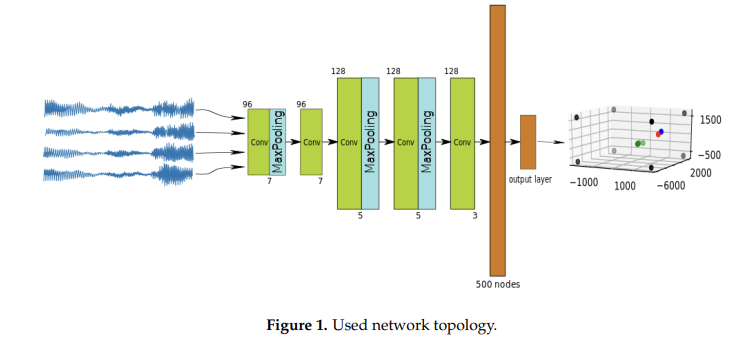

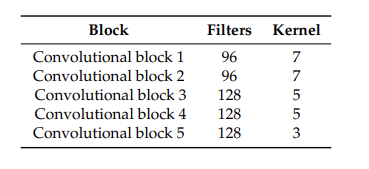

* **Input Features:** As input, only the raw audio files are fed into the network. The process is done by taking specific-sized windows from the audio sample and feed them into the neural network and the output is the 3D cartesian coordinates of the sound source.

* **Training Approach:** First a synthetic dataset is used fr training and then, the available real world samples are used to fine-tune the network.

* **Notes:** It is mentioned that in the original SELDnet article, it is claimed that predicting the x, y, and z of the DOA vector corresponding to the sound source has been more successful than outputting the angular parameters of it.

* **Article:** sensors-18-03418

## **2.DATA AUGMENTATION AND CLASS-BASED ENSEMBLED CNN-CONFORMER NETWORK:**

Here's the structure:

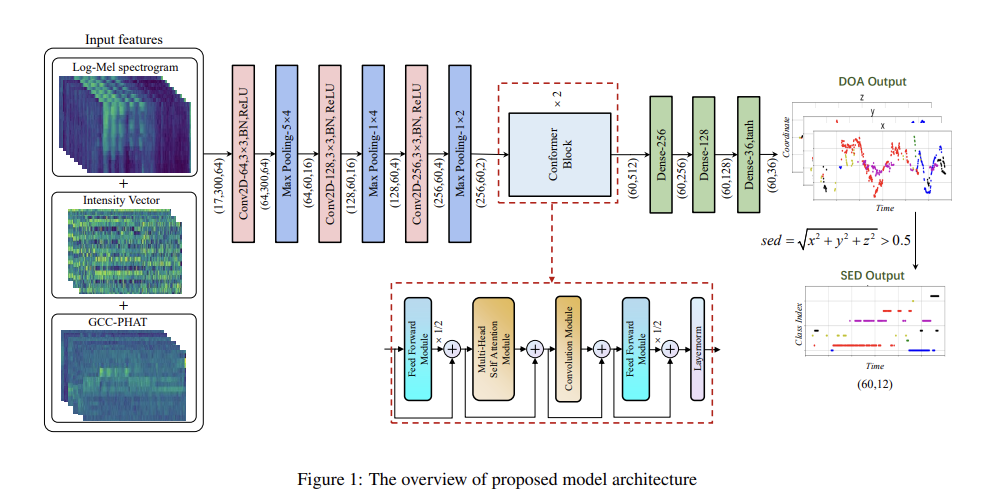

* **Input Features:** As seen in the above figure, one interesting point that can be seen in this structure is that it has used features in order to feed the neural network, which can be used in order to feed features in our own network, especially time-independent and duration-independent features like MFCCs and GCC-Phat spectrums.

* **Data Augmentation:** Data Augmantation is used in this paper which can be very helpful in our own usecase. Two of the three proposed methods can be helpful: **1. ACS** or audio channel swapping which augments data by swapping signals for channels and thus generating new samples by rotating their coordinates relatively and **2. Time Frequency Masking** which is not much explained in the paper and apparently is done in the inner parts of the network.

* **Multiple Models:** Multiple models are introduced in the article which have the similar base represented in the above figure and for example they differ in the number of conformers or such thing!

* **Ensemble Model:** An ensemble model is introduced which takes a weighted sum of each model's prediction as the final prediction.

* Now looking, the output format of the model may also be used for outputting source coordinates.

* **Article:** DCASE2021_Zhang_67_t3

## **3.Comparison of Conv types**

This article proposes a fairly **simple** structure as the main core of the networks examined. Here's the core represented in two forms, one with RNN layers and one without it:

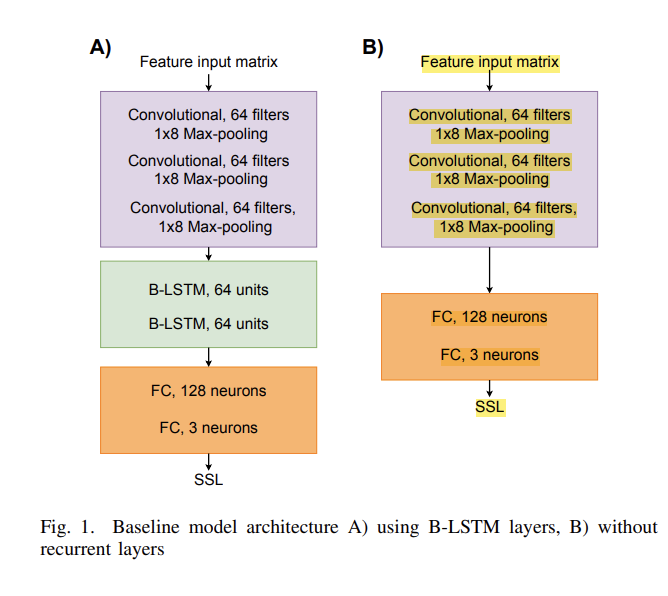

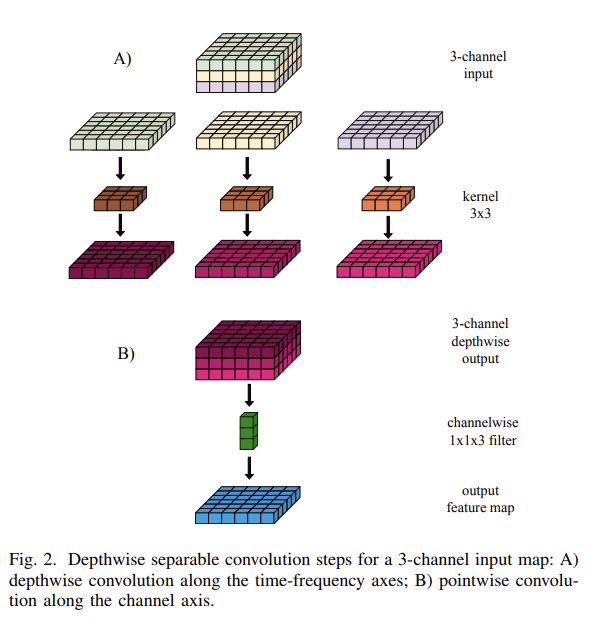

* **Experiment:** Different approaches are used and tested such as 3D conv layers or depth-wise conv layers and the performance of each, with or without using the RNN layers are reported. As utilizing the methods mentioned can be pretty hard, using the baseline modelsseem reasonable, especially the one with RNN layers as it has shown pretty good results. The question would be whether or not we can use RNN layers for our case.

* **Article:** 0000820

## **4.Multi Room CNN and MLP Network**



Following is the abstract structure of the network and does not neccessarily represent the used structure: (Important figures are followed)

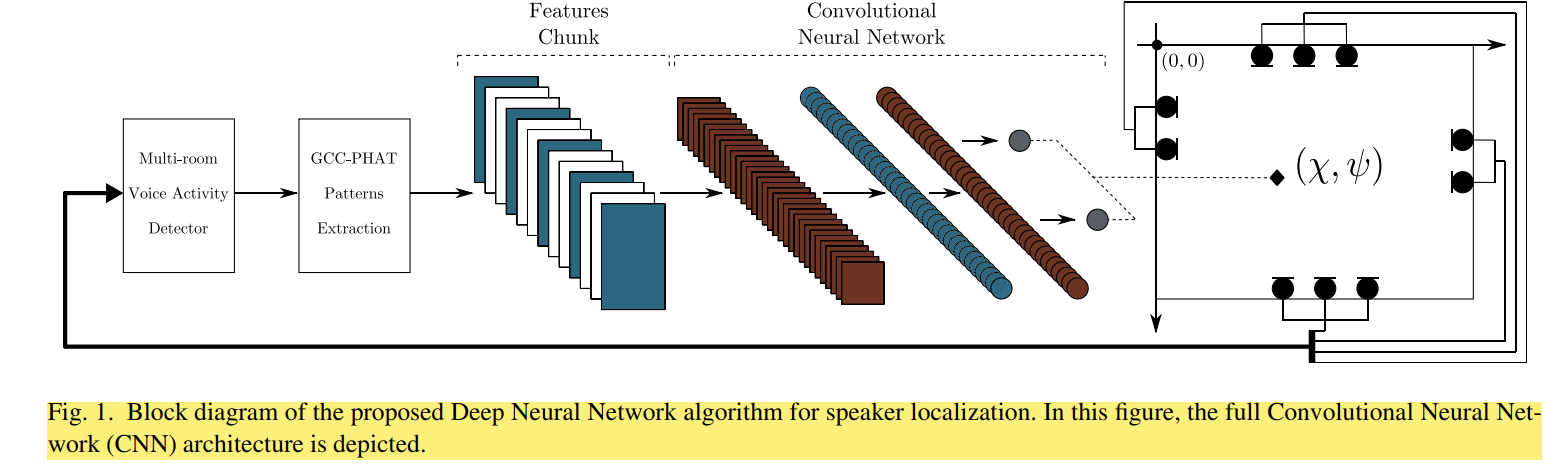

* **Summary:** In this article, one MLP and one CNN is examined in terms of their performance for localization.

* **Input Features:** As depicted in the above figure, the GCC-PHAT patterns are extracted and fed to the CNN network as images. For the MLP structure, the matrices are flattened and then fed to the network. One thing experienced here that is probably not appliable in our case is that in a section, the network is fed from the GCC-PHAT patterns of multiple windows and thus, giving it a temporal context so the network can investigate the pattern in a temporal way, shown to have generated better results and lower error.

* **Optimization:** Several Optimizations have been done in terms of the architecture of the network, the portion of the input matrice to be used, etc. The following shows the parameters examined for optimization:

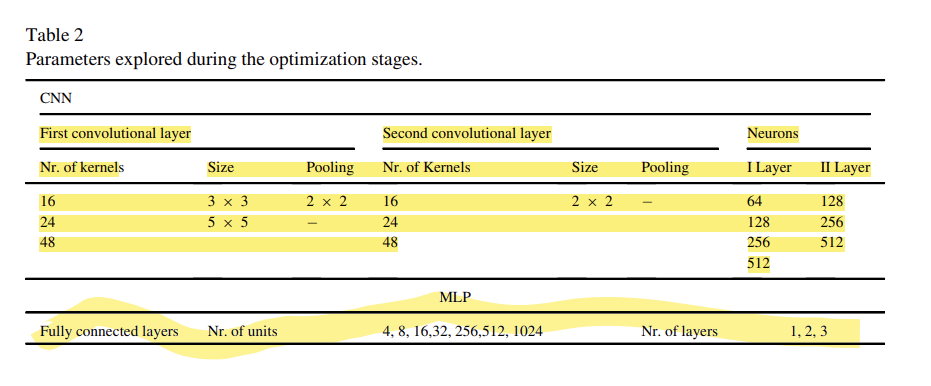

Early stopping and k-fold croos-validation has been used as well along with Adam optimizer:

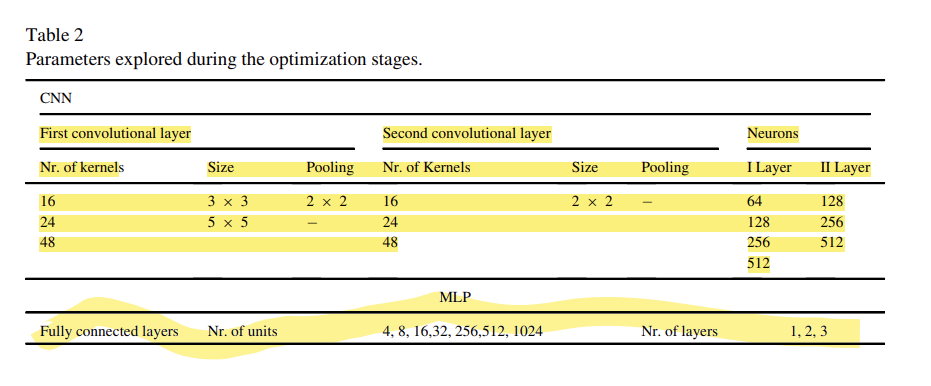

Here are the reported best hyperparameters which will probably differ in our case:

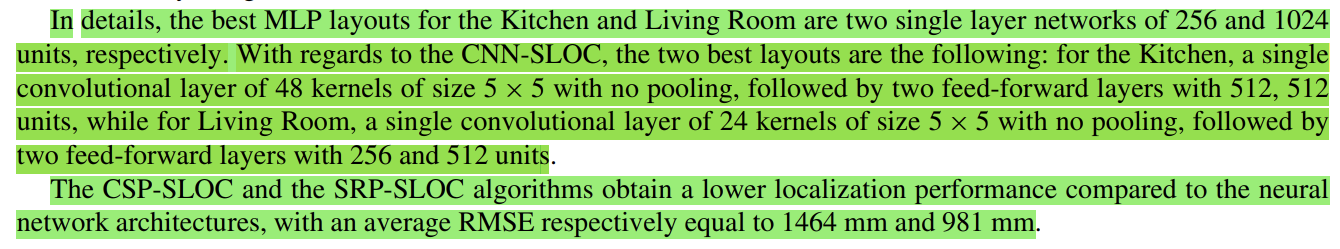

* **Results:** Without feeding the temproal contexts to the network, it is shown that the MLP architecture have better results, although the case is inverted when the temproal context in included, leading to a better overall result:

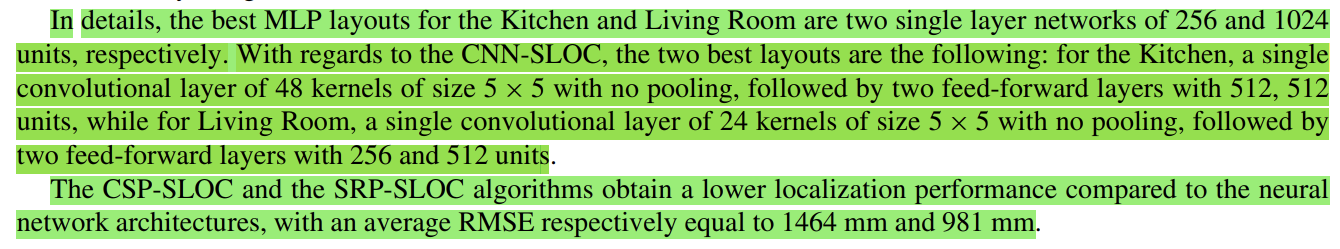

* **DataSet:** Two dataset from the DIRHA dataset have been used. The first one is the simulated dataset and the second one are the real samples. The latter has a moving speaker while the speaker in the simulated dataset is stationary.

* **Smoothing:** Smoothing between the predictions of the consecutive frames is applied and is shown to have better results and lower error.

* **Ideal:** The ideal point that this article which is from 2017 is after, is to find a fully *data-driven* network for the task of sound source localization.

* **Article:** Localizing_speakers_in_multiple_rooms_by

## **5.Baseline SELDnet**

Here's the proposed structure:

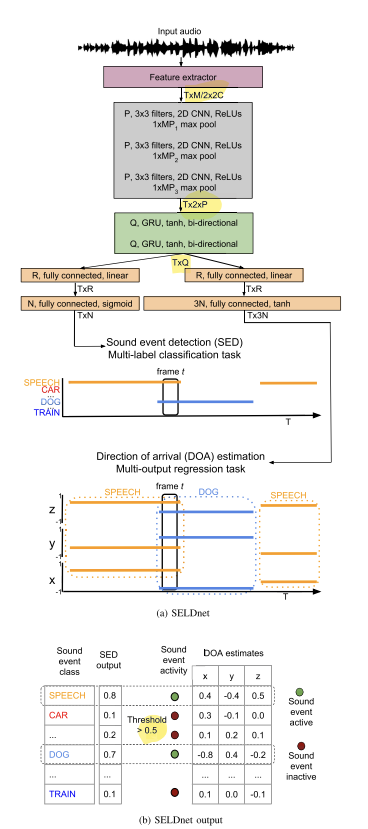

It's said that the authors were after a model that can generalize on any microphone geometry, not knowing the position vlues of the environment, in other words, reaching a complete data-driven method using a deep learning model would be the ideal goal.

* **Input Features:** The phase and magnitude spectograms are obtained in the feature extractor component. T frames from the recording sample are developed, each with the length of M bins (half of them are used) and 2C consists of C magnitutude and C phase components. Again, we have the problem of not having same lenght samples, thus we would have to modify this part and use a duration-independent feature in order to feed our network.

* **GRU Layers:** As dealing with temporal context, the GRU layers are added making the structure a CRNN which is shown to have better results. We will omit this layers upon use as we won't have any temporal context (T would be equal to 1 in our case)

* **SED Branch:** We won't need this branch as we won't need any sound event classification.

* One idea would be to use the same random forest for surface classification and just regress X and Y values by our network.

* Looking to the network, and omitting the GRU layers, we'll basically deal with a CNN network which is very similar to the one shown in the precvious article. In other words, we can start by developing a CNN model with the reasoning of seeing this approach is several articles for non-temporal input features such as the one used here and the one used in the previous article. Also, it reached a reliable intial result, we can start testing different setups of kinects just like we did in the parametric (classic) approach and compare the results of different setups.

* Probably not going to work especially as we'll be dealing with CNNs, feeding the pure TDOA values obtained from the GCC-PHAT applied to the 4-channel audio samples could be a method. This method of feeding the input can be used in MLP if used.

* **DataSet:** Around 7 datasets is used in this article, amongst which there exists datasets developed by the authors as well.

* We ultimately would need to use a dataset in which the sound source is statoinary, the microphone array is preferably linear (not neccessary if using a claimed general architecture) and the actual coordinates (not the DOA vector coordinates) is provided.

* **Article:** sap_Adavanne2019

## **Some Reflections**

* First, we need a dataset as close as possible to our own setup environment. Linear array, stationary source, actual coordinates given.

* After finding such dataset, then we need to find a method in which we can extract duration-independent features. GCC-PHAT features category seems one of the few options.

* Then, it appears that using a CNN network shown above in several occasions in the way. Classification is better to be done seperately using a random forest. Altough the details may differ as the samples now have only one ball bounce. Hence, a new feature map should be made and then we can evaluate the performance of the random forest for surface classification.

* I need to extract the same final 20 samples from all of the samples made here and treat them seperately as the test samples both for classification and localization tasks.

# **Main**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Sample Handling**

In [ ]:
# Extract final samples from all the samples
import os, re

def extract_coors(file_name, onlycoors=True):
    numbers = re.findall(r'\d+', file_name)
    numbers = list(map(int, numbers))
    if numbers[2] == 75:
        numbers[2] = 74
    if onlycoors:
        return numbers[:3]
    else:
        return numbers

def extract_coors_of_path(folder_path):
    coors = []
    for file_str in os.listdir(folder_path):
        if (file_str.endswith(".m4a") or file_str.endswith(".wav")):
            coors.append(extract_coors(file_str))
    return coors

In [ ]:
original_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K1/k1-labeled_coores'
final_coors = extract_coors_of_path(original_path)
print(f'Original Coors: (number: {len(final_coors)})\n', final_coors, end='')

Original Coors: (number: 20)
 [[5, 5, 0], [60, 4, 0], [102, 26, 0], [173, 69, 0], [4, 192, 0], [137, 193, 0], [185, 191, 0], [232, 189, 0], [56, 338, 0], [109, 327, 0], [227, 392, 0], [223, 284, 0], [78, 340, 74], [150, 360, 74], [210, 360, 74], [100, 340, 74], [170, 380, 74], [75, 395, 74], [200, 395, 74], [277, 5, 0]]

In [ ]:
import shutil

def move_samples(source_folder, dest_folder, orig_coors):
    counter = 0
    for file_name in os.listdir(source_folder):
        if file_name.startswith('ch') and file_name.endswith('.wav'):
            temp_inf = extract_coors(file_name, onlycoors=False)
            temp_coor = temp_inf[1:4]
            if temp_coor in final_coors:
                shutil.move(source_folder + '/' + file_name, dest_folder + '/' + file_name)
                print(f'Moved sample {file_name} with coor {temp_coor}.')
                counter += 1
    print(f'Total Number of moved Samples from {source_folder} to {dest_folder}: {counter}\n**************\n')

In [ ]:
source_k1 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/divided/K1'
dest_k1 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/final_samples/K1'
source_k2 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/divided/K2'
dest_k2 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/final_samples/K2'

move_samples(source_k1, dest_k1, final_coors)
move_samples(source_k2, dest_k2, final_coors)

Moved sample ch4_[170-380-74]_4.wav with coor [170, 380, 74].
Moved sample ch1_[4-192-0]_2.wav with coor [4, 192, 0].
Moved sample ch1_[4-192-0]_3.wav with coor [4, 192, 0].
Moved sample ch2_[4-192-0]_1.wav with coor [4, 192, 0].
Moved sample ch2_[4-192-0]_3.wav with coor [4, 192, 0].
Moved sample ch3_[4-192-0]_1.wav with coor [4, 192, 0].
Moved sample ch3_[4-192-0]_2.wav with coor [4, 192, 0].
Moved sample ch4_[4-192-0]_1.wav with coor [4, 192, 0].
Moved sample ch4_[4-192-0]_2.wav with coor [4, 192, 0].
Moved sample ch4_[4-192-0]_3.wav with coor [4, 192, 0].
Moved sample ch1_[5-5-0]_2.wav with coor [5, 5, 0].
Moved sample ch1_[5-5-0]_3.wav with coor [5, 5, 0].
Moved sample ch1_[5-5-0]_4.wav with coor [5, 5, 0].
Moved sample ch2_[5-5-0]_1.wav with coor [5, 5, 0].
Moved sample ch2_[5-5-0]_3.wav with coor [5, 5, 0].
Moved sample ch2_[5-5-0]_4.wav with coor [5, 5, 0].
Moved sample ch3_[5-5-0]_1.wav with coor [5, 5, 0].
Moved sample ch3_[5-5-0]_2.wav with coor [5, 5, 0].
Moved sample ch3_[

In [ ]:
def examine_if_any_left(source_folder, org_coors):
    left_cors = []
    for file_name in os.listdir(source_folder):
        if file_name.startswith('ch') and file_name.endswith('.wav'):
            coor = extract_coors(file_name)
            if coor in org_coors:
                left_cors.append(coor)
    return left_cors

print('Left Cors in K1 folder:', examine_if_any_left(source_k1, final_coors))
print('Left Cors in K2 folder:', examine_if_any_left(source_k2, final_coors))

Left Cors in K1 folder: []
Left Cors in K2 folder: []


In [ ]:
def get_different_samples(folder1, folder2):
    unseen_in_2 = []
    for file_name in os.listdir(folder1):
        if file_name.startswith('ch') and file_name.endswith('.wav'):
            if file_name not in os.listdir(folder2):
                unseen_in_2.append(file_name)

    unseen_in_1 = []
    for file_name in os.listdir(folder2):
        if file_name.startswith('ch') and file_name.endswith('.wav'):
            if file_name not in os.listdir(folder1):
                unseen_in_1.append(file_name)
    return unseen_in_1, unseen_in_2

uns1, uns2 = get_different_samples(dest_k1, dest_k2)
print('Unseen in K1 from K2', uns1)
print('Unseen in K2 from K1', uns2)

Unseen in K1 from K2 ['ch4_[170-380-74]_4.wav', 'ch1_[170-380-74]_4.wav', 'ch2_[170-380-74]_4.wav', 'ch3_[170-380-74]_4.wav']
Unseen in K2 from K1 []


## **GCC-PHAT Pattern**

### **Train Patterns for K1**

In [ ]:
source_k1 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/divided/K1'
dest_k1 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/final_samples/K1'
source_k2 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/divided/K2'
dest_k2 = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/final_samples/K2'

In [ ]:
def reshape_samples(first, sec):
    if first.shape[0] > sec.shape[0]:
        first = first[:sec.shape[0]]
    else:
        sec = sec[:first.shape[0]]
    return first, sec

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=10):

    # reshape_samples
    sig, refsig = reshape_samples(sig, refsig)

    # Get summation of the shapes of two signals
    n = np.shape(sig)[0] + np.shape(refsig)[0]

    # applies hanning window before DRFFT (discrete real fast fourier transform)
    window = np.hanning(len(sig))

    # applies FFT on both signals and gets the cross power spectral density (CPSD)
    SIG = np.fft.rfft(sig*window, n=n)
    REFSIG = np.fft.rfft(refsig*window, n=n)
    G = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(G / np.abs(G), n=(interp * n))

    # where to shift xcorr graph to get negative tau
    shift = int(interp * n / 2)

    if max_tau:
        shift = np.minimum(int(interp * fs * max_tau), shift)

    cc = np.concatenate((cc[-shift:], cc[:shift + 1]))

    # find max cross correlation index
    argmax = np.argmax(cc) - shift

    indices = (np.linspace(0, cc.shape[0], cc.shape[0]) - shift) / float(interp * fs)
    tau = argmax / float(interp * fs)

    return [tau, cc, indices]

4.536729788450454e-07 4.5367297884482856e-07


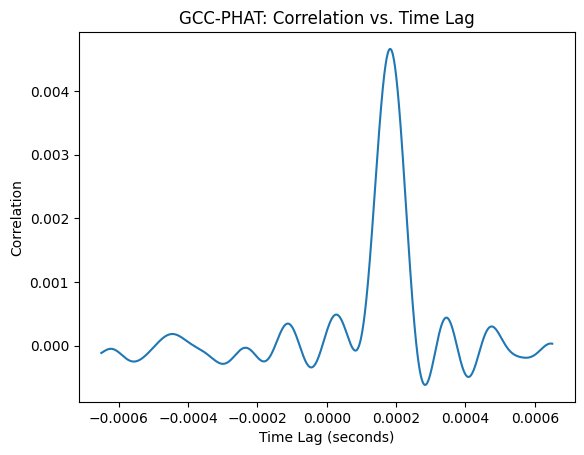

TDOA value: 0.00018276643990929706
[-0.00064989 -0.00064943 -0.00064898 ...  0.00064943  0.00064989
  0.00065034]


In [ ]:
first_sample_name = 'ch4_[272-188-0]_3.wav'
sec_sample_name = 'ch3_[272-188-0]_3.wav'
first_sample_path = source_k1 + '/' + first_sample_name
sec_sample_path = source_k1 + '/' + sec_sample_name
sample1, sr = librosa.load(first_sample_path, sr=None)
sample2, sr = librosa.load(sec_sample_path, sr=None)
sample1, sample2 = reshape_samples(sample1, sample2)

tdoa, cc, lags = gcc_phat(sample1, sample2, sr, max_tau=6.5e-4)
print(lags[1] - lags[0], lags[2] - lags[1])
# Plot correlation values against lag
plt.plot(lags, cc)
plt.title('GCC-PHAT: Correlation vs. Time Lag')
plt.xlabel('Time Lag (seconds)')
plt.ylabel('Correlation')
plt.show()
print('TDOA value:', tdoa)
print(lags)


In [ ]:
# tdoa margin values
min_tdoa = -6.58892e-4
max_tdoa = 6.58892e-4
resolution = 4.55100e-7
grid_num = (max_tdoa - min_tdoa) / resolution
num_mic_pairs = 6

def generate_file_names(sample_name):
    file_names = []
    for i in range(4):
        new_name = f'ch{i+1}_' + sample_name + '.wav'
        file_names.append(new_name)
    return file_names

def create_stacked_gcc(sample_names, sample_folder):
    channels = []
    for smp_name in sample_names:
        file_path = sample_folder + '/' + smp_name
        y_temp, sr = librosa.load(file_path)
        channels.append(y_temp)

    seen_flag = False
    gccs_inf = {}
    num_mic_pairs = 0
    for i in range(len(channels)):
        for j in range(i+1, len(channels)):
            [tdoa, gcc, lags] = gcc_phat(channels[i], channels[j], sr, max_tau=max_tdoa)
            str_idx = f'tdoa{i}{j}'
            gccs_inf[str_idx] = [tdoa, gcc, lags]
            gcc_normalized = 2 * (gcc - np.min(gcc)) / (np.max(gcc) - np.min(gcc)) - 1
            if not seen_flag:
                stacked_grid = np.array(gcc_normalized)
                seen_flag = True
            else:
                stacked_grid = np.vstack((gcc_normalized, stacked_grid))
    return stacked_grid, gccs_inf

[('tdoa01', 0.00023628117913832198), ('tdoa02', 0.00018276643990929706), ('tdoa03', 0.00020770975056689343), ('tdoa12', -5.0340136054421766e-05), ('tdoa13', -2.4943310657596373e-05), ('tdoa23', 2.857142857142857e-05)]


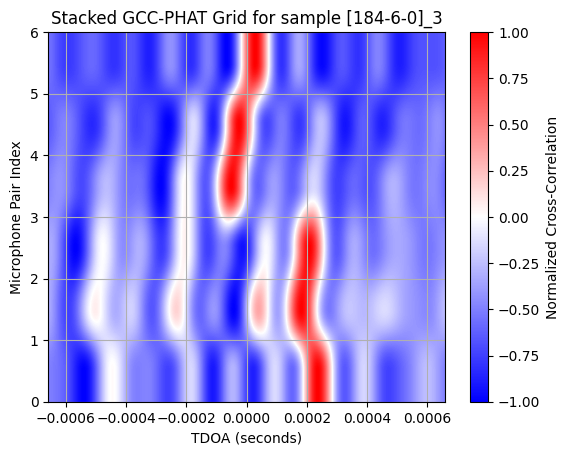

In [ ]:
sample = '[184-6-0]_3'
sample_folder = source_k1
sample_names = generate_file_names(sample)
stacked_gccs, gcc_information = create_stacked_gcc(sample_names, sample_folder)

# print information
print([(tdoa_name, vals[0]) for (tdoa_name, vals) in gcc_information.items()])

# Plotting the stacked grids
plt.imshow(stacked_gccs, aspect='auto', cmap='bwr', extent=[min_tdoa, max_tdoa, 0, num_mic_pairs])
plt.title(f'Stacked GCC-PHAT Grid for sample {sample}')
plt.xlabel('TDOA (seconds)')
plt.ylabel('Microphone Pair Index')
plt.colorbar(label='Normalized Cross-Correlation')
plt.grid(True)
plt.show()

In [ ]:
print(len(stacked_gccs[0]))

2905


In [ ]:
from numpy.random import randint
import os

def extract_sample_name_format(name):
    start = name.find('[')
    end = name.find('.')
    return name[start:end]

def create_stacked_gcc_and_label_for_folder(sample_folder):
    patterns = []
    labels = []
    seen_samples = []
    for file_name in os.listdir(sample_folder):
        if file_name.startswith('ch') and file_name.endswith('.wav'):
            formatted_name = extract_sample_name_format(file_name)
            if formatted_name in seen_samples:
                continue
            else:
                temp_inf = extract_coors(file_name, onlycoors=False)
                temp_coors = temp_inf[1:4]
                labels.append(temp_coors)
                seen_samples.append(formatted_name)
                sample_names = generate_file_names(formatted_name)
                stacked_gcc, _ = create_stacked_gcc(sample_names, sample_folder)
                patterns.append(stacked_gcc)
    return patterns, labels

def plot_random_patterns(rand_num, sample_num, patterns, labels):
    rand_nums = randint(0, high=sample_num-1, size=rand_num)
    num_rows = (rand_num + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))
    axes = axes.flatten()
    for i in range(len(rand_nums)):
        lbl = labels[rand_nums[i]]
        axes[i].imshow(patterns[rand_nums[i]], aspect='auto', cmap='bwr', extent=[min_tdoa, max_tdoa, 0, num_mic_pairs])
        axes[i].set_title(f'Stacked GCC-PHAT Grid for sample {lbl}')
        axes[i].set_xlabel('TDOA (seconds)')
        axes[i].set_ylabel('Microphone Pair Index')
        axes[i].grid(True)
    # Turn off any unused subplots
    for j in range(rand_num, len(axes)):
        fig.delaxes(axes[j])
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [ ]:
patterns_K1, labels_k1 = create_stacked_gcc_and_label_for_folder(source_k1)

KeyboardInterrupt: 

In [ ]:
print(labels_k1)

In [ ]:
print(len(patterns_K1), len(labels_k1))

138 138


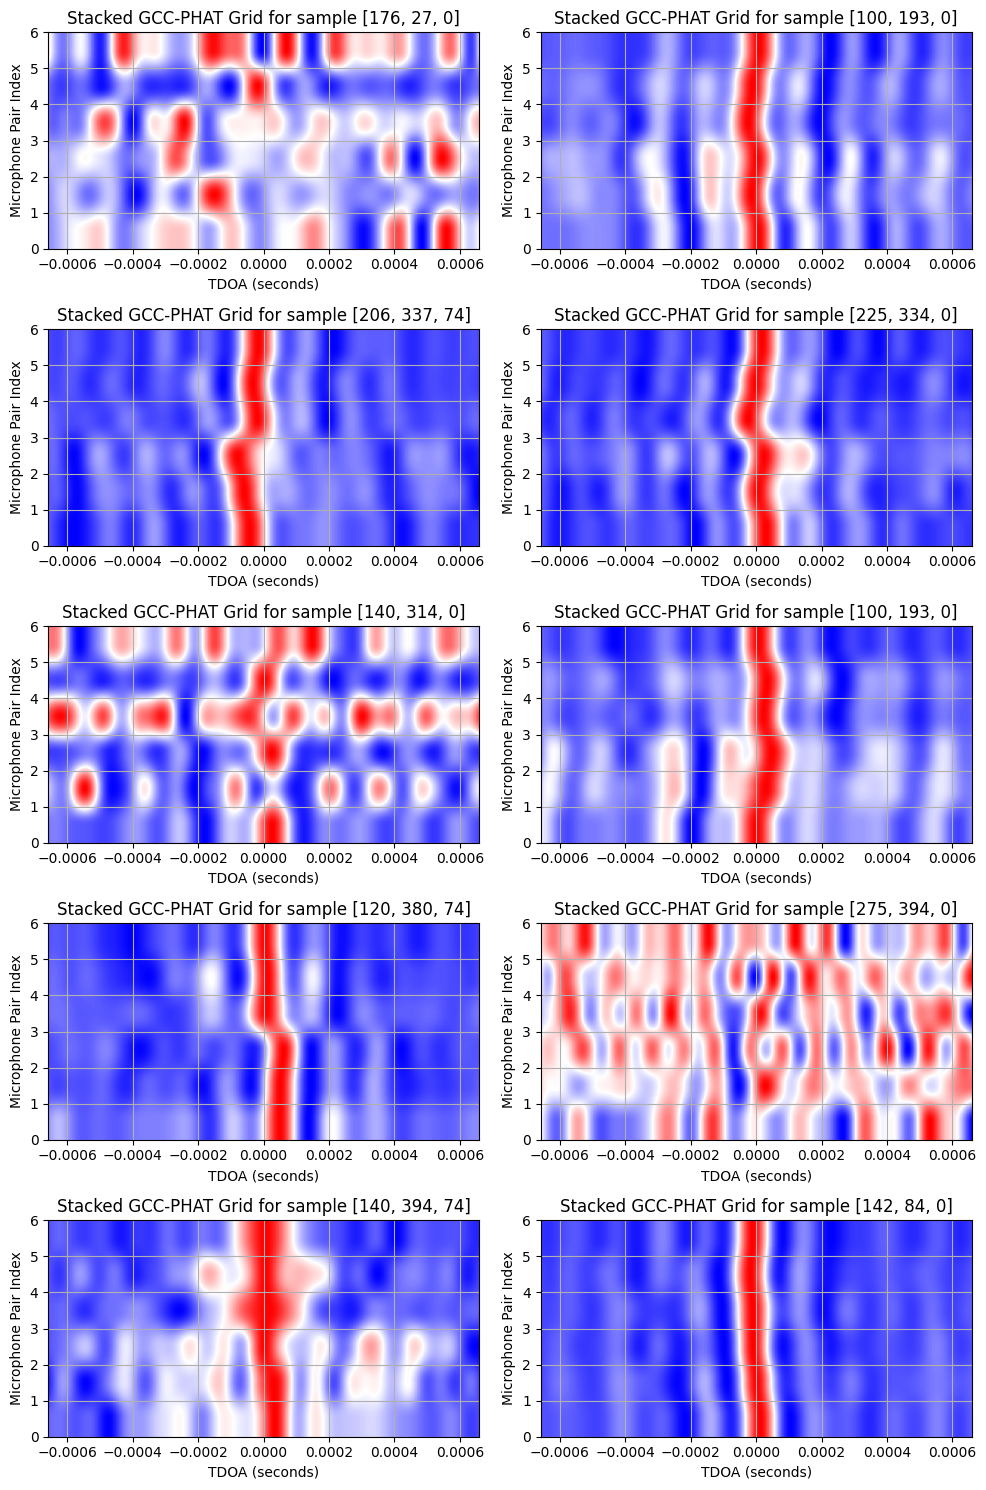

In [ ]:
plot_random_patterns(10, len(patterns_K1), patterns_K1, labels_k1)

In [ ]:
import pickle

# Save patterns to a file
destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/patterns100.pkl'
with open(destination_dir, 'wb') as file:
    pickle.dump(patterns_K1, file)
print("List saved to file successfully.")

# Save labels to a file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/labels100.pkl'
with open(lbl_destination_dir, 'wb') as file:
    pickle.dump(labels_k1, file)
print("List saved to file successfully.")

List saved to file successfully.
List saved to file successfully.


In [ ]:
import pickle

# Load from the file
destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/patterns100.pkl'
with open(destination_dir, 'rb') as file:
    pattern_loaded_list = pickle.load(file)
print("List loaded from file successfully.")

# Load labels from the file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/labels100.pkl'
with open(lbl_destination_dir, 'rb') as file:
    lbl_loaded_list = pickle.load(file)
print("List loaded from file successfully.")
print(len(pattern_loaded_list), len(lbl_loaded_list))

List loaded from file successfully.
List loaded from file successfully.
138 138


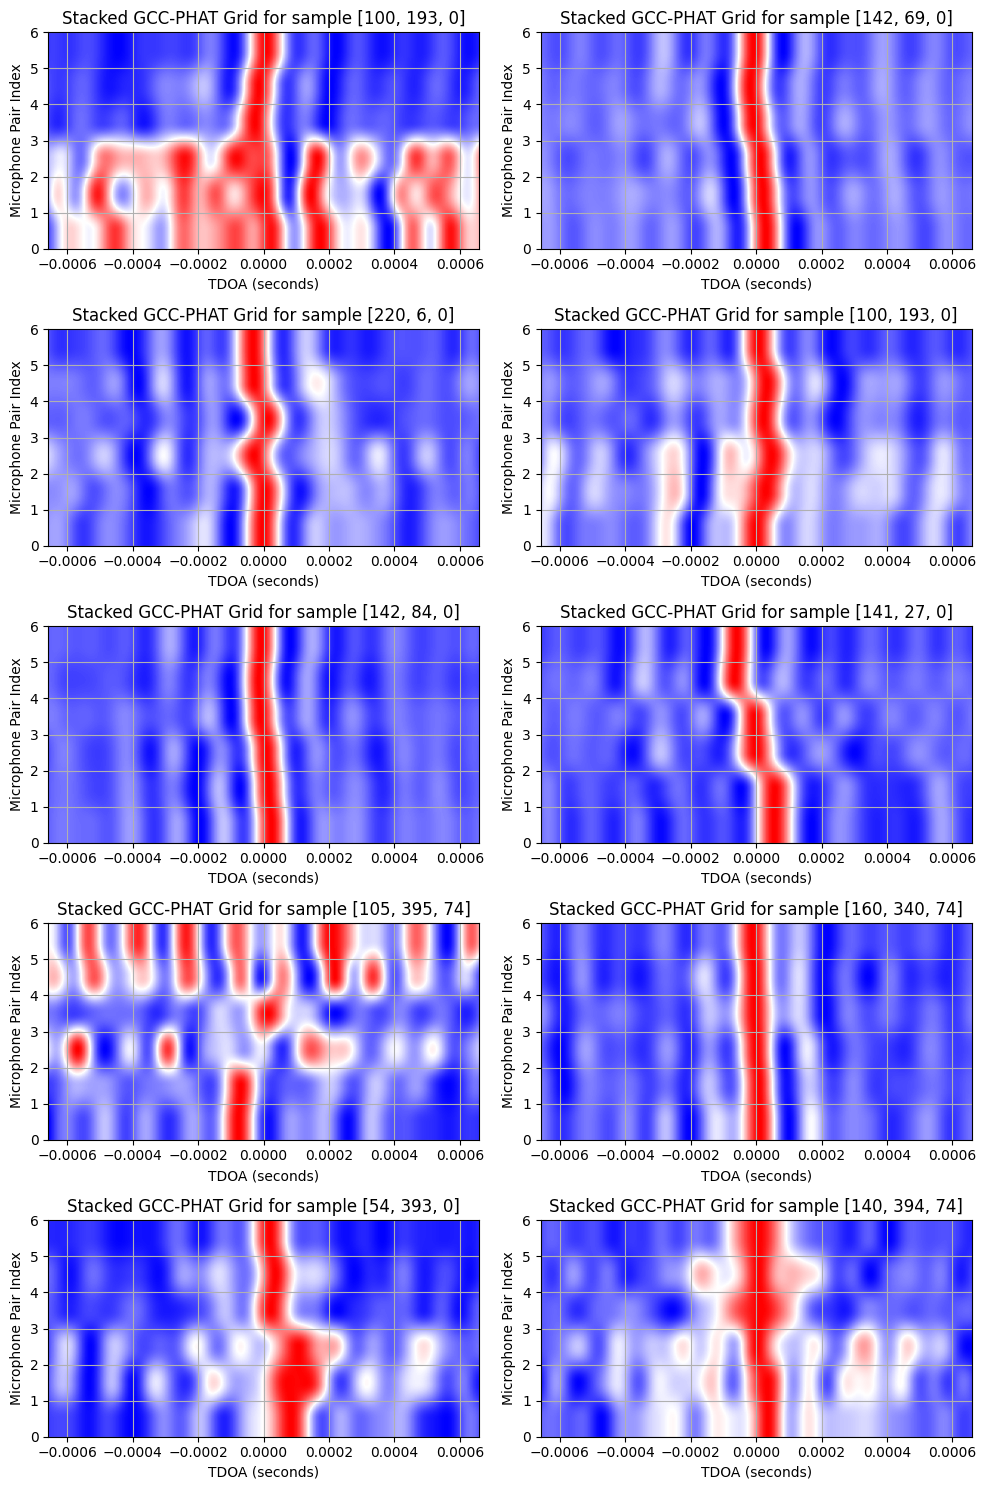

In [ ]:
plot_random_patterns(10, len(pattern_loaded_list), loaded_list, lbl_loaded_list)

### **Train patterns for K2**

In [ ]:
patterns_K2, labels_k2 = create_stacked_gcc_and_label_for_folder(source_k2)

In [ ]:
print(labels_k2)

[[75, 385, 74], [75, 385, 74], [75, 385, 74], [100, 193, 0], [100, 193, 0], [100, 193, 0], [100, 193, 0], [102, 6, 0], [102, 6, 0], [102, 6, 0], [102, 6, 0], [105, 395, 74], [105, 395, 74], [105, 395, 74], [105, 395, 74], [107, 358, 74], [107, 358, 74], [107, 358, 74], [107, 358, 74], [115, 69, 0], [115, 69, 0], [115, 69, 0], [115, 69, 0], [120, 380, 74], [120, 380, 74], [120, 380, 74], [120, 380, 74], [126, 208, 0], [126, 208, 0], [126, 208, 0], [126, 208, 0], [130, 340, 74], [130, 340, 74], [130, 340, 74], [140, 227, 0], [140, 227, 0], [140, 227, 0], [140, 314, 0], [140, 314, 0], [140, 314, 0], [140, 314, 0], [140, 394, 74], [140, 394, 74], [140, 394, 74], [140, 394, 74], [141, 27, 0], [141, 27, 0], [141, 27, 0], [141, 27, 0], [142, 69, 0], [142, 69, 0], [142, 69, 0], [142, 69, 0], [142, 84, 0], [142, 84, 0], [142, 84, 0], [142, 84, 0], [146, 154, 0], [146, 154, 0], [146, 154, 0], [146, 154, 0], [160, 340, 74], [160, 340, 74], [160, 340, 74], [160, 340, 74], [171, 328, 0], [171, 328,

In [ ]:
print(len(patterns_K2), len(labels_k2))

140 140


In [ ]:
import pickle

# Save patterns to a file
destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/patterns.pkl'
with open(destination_dir, 'wb') as file:
    pickle.dump(patterns_K2, file)
print("List saved to file successfully.")

# Save labels to a file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/labels.pkl'
with open(lbl_destination_dir, 'wb') as file:
    pickle.dump(labels_k2, file)
print("List saved to file successfully.")

List saved to file successfully.
List saved to file successfully.


In [ ]:
import pickle

# Load from the file
destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/patterns.pkl'
with open(destination_dir, 'rb') as file:
    k2_pattern_loaded_list = pickle.load(file)
print("List loaded from file successfully.")

# Load labels from the file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/labels.pkl'
with open(lbl_destination_dir, 'rb') as file:
    k2_lbl_loaded_list = pickle.load(file)
print("List loaded from file successfully.")
print(len(k2_pattern_loaded_list), len(k2_lbl_loaded_list))

List loaded from file successfully.
List loaded from file successfully.
140 140


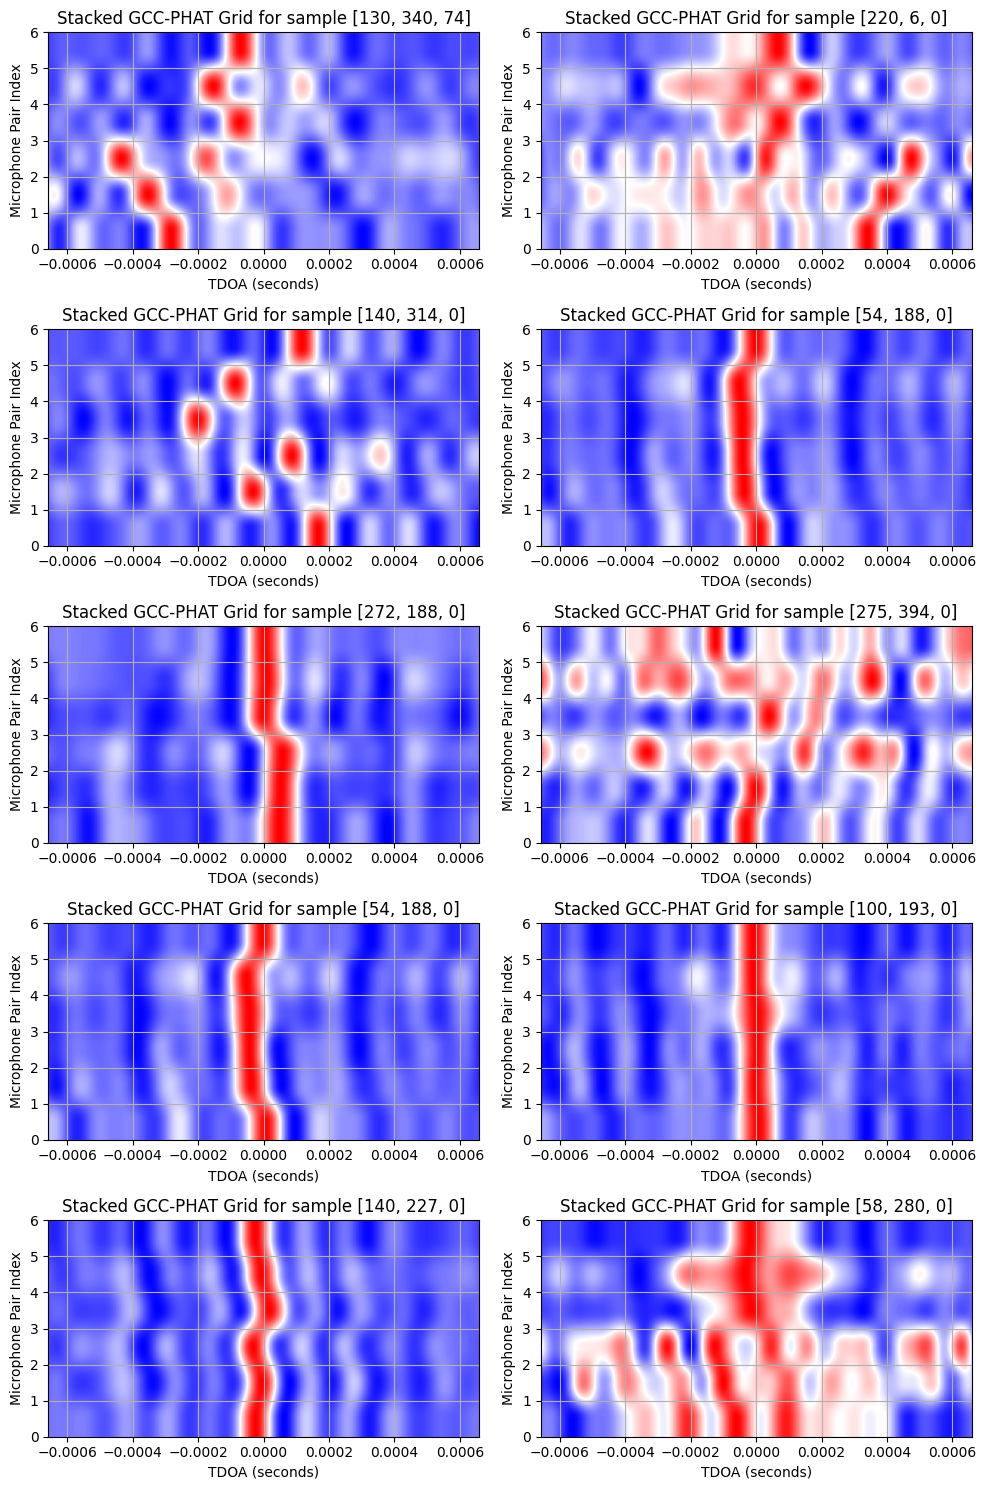

In [ ]:
plot_random_patterns(10, len(k2_pattern_loaded_list), k2_pattern_loaded_list, k2_lbl_loaded_list)

### **Test patterns for K1**

In [ ]:
test_patterns_K1, test_labels_k1 = create_stacked_gcc_and_label_for_folder(dest_k1)

In [ ]:
print(test_labels_k1)

[[4, 192, 0], [4, 192, 0], [4, 192, 0], [5, 5, 0], [5, 5, 0], [5, 5, 0], [5, 5, 0], [56, 338, 0], [56, 338, 0], [56, 338, 0], [56, 338, 0], [60, 4, 0], [60, 4, 0], [60, 4, 0], [60, 4, 0], [75, 395, 74], [75, 395, 74], [75, 395, 74], [75, 395, 74], [78, 340, 74], [78, 340, 74], [78, 340, 74], [78, 340, 74], [100, 340, 74], [100, 340, 74], [100, 340, 74], [100, 340, 74], [102, 26, 0], [102, 26, 0], [102, 26, 0], [102, 26, 0], [109, 327, 0], [109, 327, 0], [109, 327, 0], [137, 193, 0], [137, 193, 0], [137, 193, 0], [137, 193, 0], [150, 360, 74], [150, 360, 74], [150, 360, 74], [150, 360, 74], [170, 380, 74], [170, 380, 74], [170, 380, 74], [173, 69, 0], [173, 69, 0], [173, 69, 0], [173, 69, 0], [185, 191, 0], [185, 191, 0], [185, 191, 0], [185, 191, 0], [200, 395, 74], [200, 395, 74], [200, 395, 74], [200, 395, 74], [210, 360, 74], [210, 360, 74], [210, 360, 74], [223, 284, 0], [223, 284, 0], [223, 284, 0], [223, 284, 0], [227, 392, 0], [227, 392, 0], [227, 392, 0], [227, 392, 0], [277, 5

In [ ]:
print(len(test_patterns_K1), len(test_labels_k1))

76 76


In [ ]:
import pickle

# Save patterns to a file
test_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/test/patterns.pkl'
with open(test_destination_dir, 'wb') as file:
    pickle.dump(test_patterns_K1, file)
print("List saved to file successfully.")

# Save labels to a file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/test/labels.pkl'
with open(lbl_destination_dir, 'wb') as file:
    pickle.dump(test_labels_k1, file)
print("List saved to file successfully.")

List saved to file successfully.
List saved to file successfully.


In [ ]:
import pickle

# Load from the file
test_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/test/patterns.pkl'
with open(test_destination_dir, 'rb') as file:
    K1_test_patterns = pickle.load(file)
print("List loaded from file successfully.")

# Load labels from the file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K1 info/test/labels.pkl'
with open(lbl_destination_dir, 'rb') as file:
    K1_test_labels = pickle.load(file)
print("List loaded from file successfully.")
print(len(K1_test_patterns), len(K1_test_labels))

List loaded from file successfully.
List loaded from file successfully.
76 76


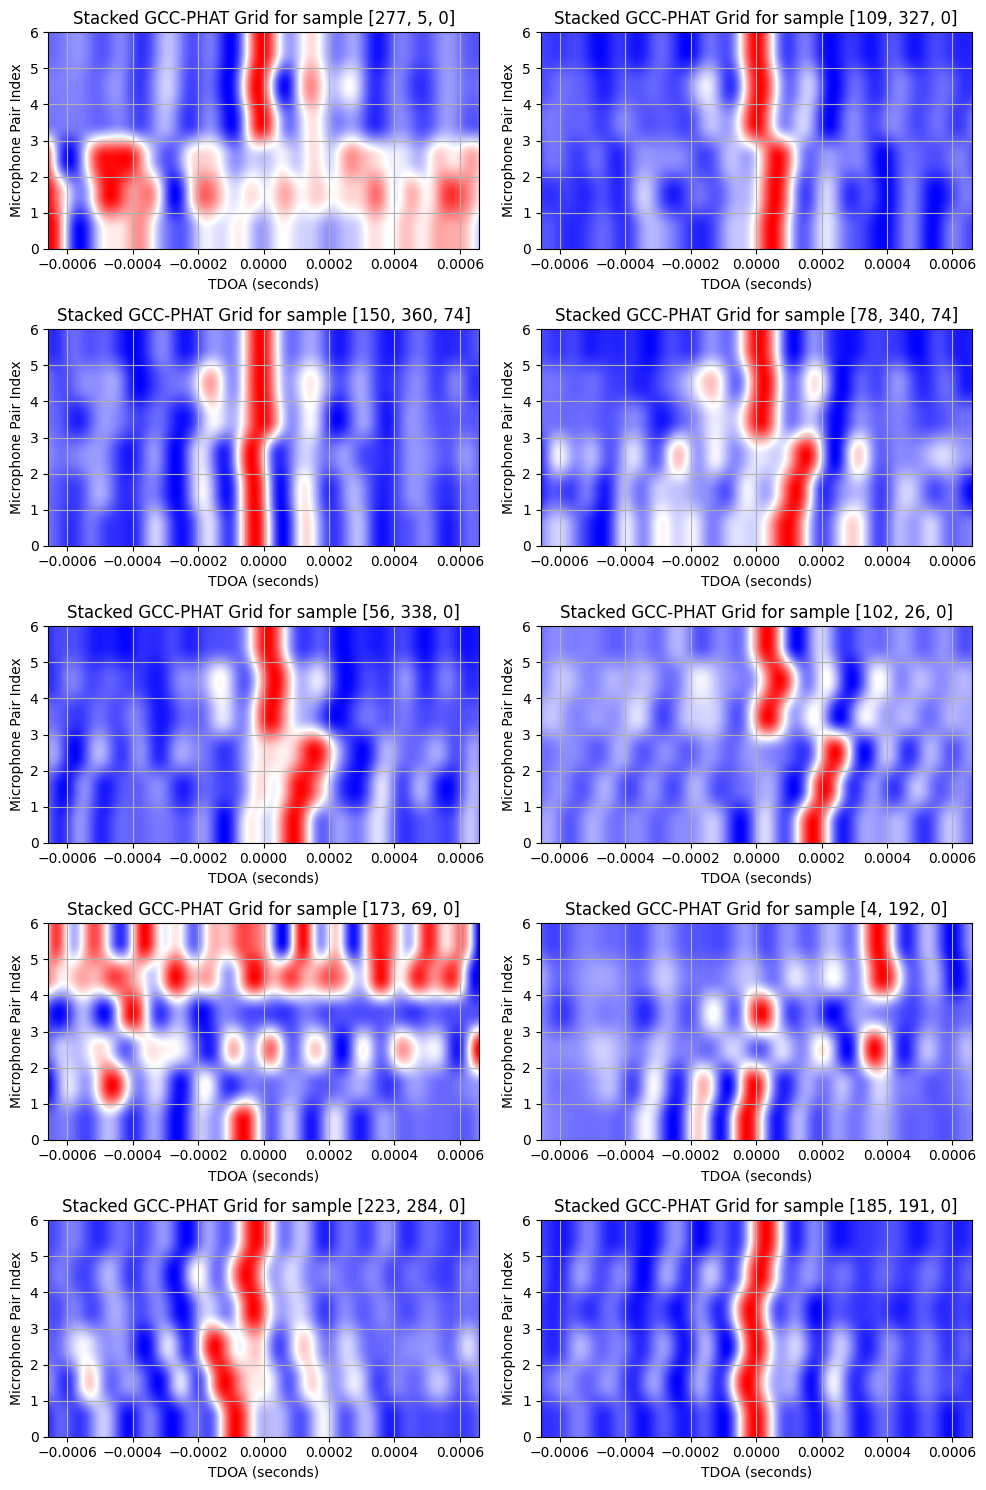

In [ ]:
plot_random_patterns(10, len(K1_test_patterns), K1_test_patterns, K1_test_labels)

### **Test patterns for K2**

In [ ]:
test_patterns_K2, test_labels_k2 = create_stacked_gcc_and_label_for_folder(dest_k2)

In [ ]:
print(test_labels_k2)

[[170, 380, 74], [4, 192, 0], [4, 192, 0], [4, 192, 0], [5, 5, 0], [5, 5, 0], [5, 5, 0], [5, 5, 0], [56, 338, 0], [56, 338, 0], [56, 338, 0], [56, 338, 0], [60, 4, 0], [60, 4, 0], [60, 4, 0], [60, 4, 0], [75, 395, 74], [75, 395, 74], [75, 395, 74], [75, 395, 74], [78, 340, 74], [78, 340, 74], [78, 340, 74], [78, 340, 74], [100, 340, 74], [100, 340, 74], [100, 340, 74], [100, 340, 74], [102, 26, 0], [102, 26, 0], [102, 26, 0], [102, 26, 0], [109, 327, 0], [109, 327, 0], [109, 327, 0], [137, 193, 0], [137, 193, 0], [137, 193, 0], [137, 193, 0], [150, 360, 74], [150, 360, 74], [150, 360, 74], [150, 360, 74], [170, 380, 74], [170, 380, 74], [170, 380, 74], [173, 69, 0], [173, 69, 0], [173, 69, 0], [173, 69, 0], [185, 191, 0], [185, 191, 0], [185, 191, 0], [185, 191, 0], [200, 395, 74], [200, 395, 74], [200, 395, 74], [200, 395, 74], [210, 360, 74], [210, 360, 74], [210, 360, 74], [223, 284, 0], [223, 284, 0], [223, 284, 0], [223, 284, 0], [277, 5, 0], [277, 5, 0], [277, 5, 0], [277, 5, 0],

In [ ]:
print(len(test_patterns_K2), len(test_labels_k2))

77 77


In [ ]:
import pickle

# Save patterns to a file
test_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/test/patterns.pkl'
with open(test_destination_dir, 'wb') as file:
    pickle.dump(test_patterns_K2, file)
print("List saved to file successfully.")

# Save labels to a file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/test/labels.pkl'
with open(lbl_destination_dir, 'wb') as file:
    pickle.dump(test_labels_k2, file)
print("List saved to file successfully.")

List saved to file successfully.
List saved to file successfully.


In [ ]:
import pickle

# Load from the file
destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/test/patterns.pkl'
with open(destination_dir, 'rb') as file:
    K2_test_patterns = pickle.load(file)
print("List loaded from file successfully.")

# Load labels from the file
lbl_destination_dir = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/DeepNet Samples/K2 info/test/labels.pkl'
with open(lbl_destination_dir, 'rb') as file:
    K2_test_labels = pickle.load(file)
print("List loaded from file successfully.")
print(len(K2_test_patterns), len(K2_test_labels))

List loaded from file successfully.
List loaded from file successfully.
77 77


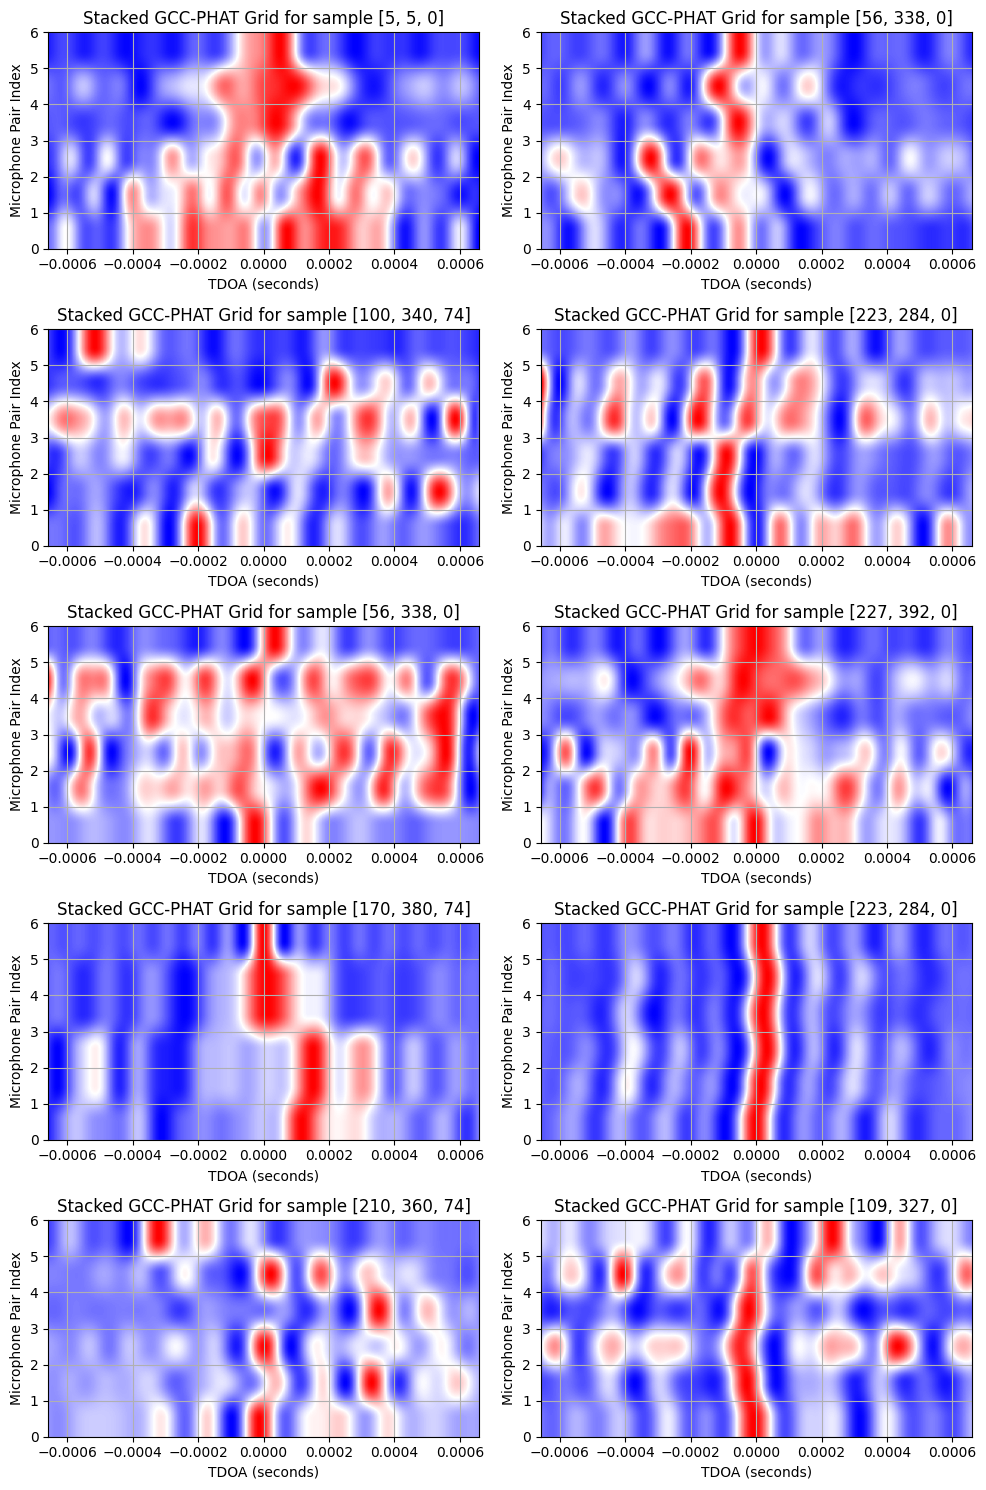

In [ ]:
plot_random_patterns(10, len(K2_test_patterns), K2_test_patterns, K2_test_labels)

### **Save Lists**

In [ ]:
import numpy as np

K1_train = {
    'patterns': np.array(pattern_loaded_list),
    'labels': np.array(lbl_loaded_list)
}
K2_train = {
    'patterns': np.array(k2_pattern_loaded_list),
    'labels': np.array(k2_lbl_loaded_list)
}
K1_test = {
    'patterns': np.array(K1_test_patterns),
    'labels': np.array(K1_test_labels)
}
K2_test = {
    'patterns': np.array(K2_test_patterns),
    'labels': np.array(K2_test_labels)
}

### **Patterns for K1 and K2, mixed**

#### **Handle train and test division**

In this segment, I'll try to split test and train so that not neccessarily all of the different impacts of a single coordinate get placed in the same category.

In [ ]:
NOT_VALID = -1

def count_cor_patterns(patterns, labels):
    if len(patterns) != len(labels):
        raise 'Unequal Length'

    count_dict = {}
    for lbl in labels:
        count_dict[tuple(lbl.tolist())] = [0, []]
    for i in range(len(patterns)):
        count_dict[tuple(labels[i].tolist())][0] += 1
        count_dict[tuple(labels[i].tolist())][1].append(patterns[i])
    return count_dict

In [ ]:
def update_count_dicts(dict1, dict2):
    total_dict = {}
    if len(dict1) != len(dict2):
        raise 'Unequal Lengths'
    else:
        for key in dict1.keys():
            total_dict[key] = []
            total_dict[key].append(dict2[key][0] + dict1[key][0])
            total_dict[key].append(dict2[key][1] + dict1[key][1])
            print(f'Merged values for {key} coordinate.')
    return total_dict

In [ ]:
all_patterns_K1 = np.vstack((K1_train['patterns'], K1_test['patterns']))
all_labels_K1 = np.vstack((K1_train['labels'], K1_test['labels']))
all_patterns_K2 = np.vstack((K2_train['patterns'], K2_test['patterns']))
all_labels_K2 = np.vstack((K2_train['labels'], K2_test['labels']))

count_dict_K1 = count_cor_patterns(all_patterns_K1, all_labels_K1)
count_dict_K2 = count_cor_patterns(all_patterns_K2, all_labels_K2)

In [ ]:
total_count_dict = update_count_dicts(count_dict_K1, count_dict_K2)

Merged values for (8, 392, 0) coordinate.
Merged values for (54, 188, 0) coordinate.
Merged values for (54, 393, 0) coordinate.
Merged values for (58, 280, 0) coordinate.
Merged values for (61, 60, 0) coordinate.
Merged values for (62, 124, 0) coordinate.
Merged values for (74, 363, 74) coordinate.
Merged values for (75, 385, 74) coordinate.
Merged values for (100, 193, 0) coordinate.
Merged values for (102, 6, 0) coordinate.
Merged values for (105, 395, 74) coordinate.
Merged values for (107, 358, 74) coordinate.
Merged values for (115, 69, 0) coordinate.
Merged values for (120, 380, 74) coordinate.
Merged values for (126, 208, 0) coordinate.
Merged values for (130, 340, 74) coordinate.
Merged values for (140, 227, 0) coordinate.
Merged values for (140, 314, 0) coordinate.
Merged values for (140, 394, 74) coordinate.
Merged values for (141, 27, 0) coordinate.
Merged values for (142, 69, 0) coordinate.
Merged values for (142, 84, 0) coordinate.
Merged values for (146, 154, 0) coordinat

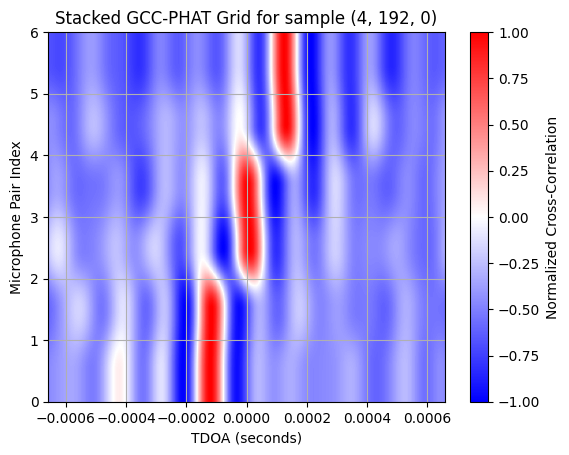

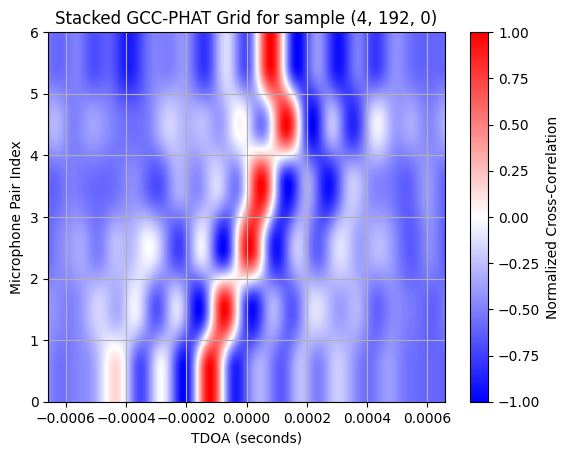

In [ ]:
plt1 = total_count_dict[(5, 5, 0)][1][4]
plt2 = total_count_dict[(5, 5, 0)][1][5]
sample = (4, 192, 0)

# Plotting the stacked grids
plt.imshow(plt1, aspect='auto', cmap='bwr', extent=[min_tdoa, max_tdoa, 0, num_mic_pairs])
plt.title(f'Stacked GCC-PHAT Grid for sample {sample}')
plt.xlabel('TDOA (seconds)')
plt.ylabel('Microphone Pair Index')
plt.colorbar(label='Normalized Cross-Correlation')
plt.grid(True)
plt.show()

# Plotting the stacked grids
plt.imshow(plt2, aspect='auto', cmap='bwr', extent=[min_tdoa, max_tdoa, 0, num_mic_pairs])
plt.title(f'Stacked GCC-PHAT Grid for sample {sample}')
plt.xlabel('TDOA (seconds)')
plt.ylabel('Microphone Pair Index')
plt.colorbar(label='Normalized Cross-Correlation')
plt.grid(True)
plt.show()

In [ ]:
original_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K1/k1-labeled_coores'
final_coors = extract_coors_of_path(original_path)
print(f'Original Coors: (number: {len(final_coors)})\n', final_coors, end='')

Original Coors: (number: 20)
 [[5, 5, 0], [60, 4, 0], [102, 26, 0], [173, 69, 0], [4, 192, 0], [137, 193, 0], [185, 191, 0], [232, 189, 0], [56, 338, 0], [109, 327, 0], [227, 392, 0], [223, 284, 0], [78, 340, 74], [150, 360, 74], [210, 360, 74], [100, 340, 74], [170, 380, 74], [75, 395, 74], [200, 395, 74], [277, 5, 0]]

In [ ]:
import copy

def extract_final_coors_single_bounce(final_crs, count_dict):
    count_dict_copy = copy.deepcopy(count_dict)
    test_dict = {}
    countnum = 0
    for label, [count, patterns] in count_dict_copy.items():
        if list(label) in final_crs:
            # Determine which pattern
            pat_len = len(patterns)
            rand_idx = np.random.randint(0, pat_len)
            print(f'Number of Patterns for cordinate {label}: {pat_len}, Chosen Index: {rand_idx}')
            # Extract that pattern
            chosen_pat = count_dict_copy[label][1].pop(rand_idx)
            count_dict_copy[label][0] -= 1
            countnum += 1
            print(f'Number of patterns after removing the chosen pattern: {count_dict_copy[label][0]}.')
            # Insert in test dict
            test_dict[label] = chosen_pat
    print('Total Number of processed Samples:', countnum)
    # Make train dictionary
    train_dict = {}
    for label, [count, patterns] in count_dict_copy.items():
        train_dict[label] = patterns

    return count_dict_copy, train_dict, test_dict

**Here for determination of how the samples are formed**

In [ ]:
# count_dict_overall, train_dict_total, test_dict_total = extract_final_coors_single_bounce(final_coors, total_count_dict)
count_dict_overall, train_dict_total, test_dict_total = extract_final_coors_single_bounce(final_coors, count_dict_K2)

Number of Patterns for cordinate (170, 380, 74): 4, Chosen Index: 3
Number of patterns after removing the chosen pattern: 3.
Number of Patterns for cordinate (4, 192, 0): 3, Chosen Index: 1
Number of patterns after removing the chosen pattern: 2.
Number of Patterns for cordinate (5, 5, 0): 4, Chosen Index: 2
Number of patterns after removing the chosen pattern: 3.
Number of Patterns for cordinate (56, 338, 0): 4, Chosen Index: 3
Number of patterns after removing the chosen pattern: 3.
Number of Patterns for cordinate (60, 4, 0): 4, Chosen Index: 1
Number of patterns after removing the chosen pattern: 3.
Number of Patterns for cordinate (75, 395, 74): 4, Chosen Index: 1
Number of patterns after removing the chosen pattern: 3.
Number of Patterns for cordinate (78, 340, 74): 4, Chosen Index: 3
Number of patterns after removing the chosen pattern: 3.
Number of Patterns for cordinate (100, 340, 74): 4, Chosen Index: 1
Number of patterns after removing the chosen pattern: 3.
Number of Patter

In [ ]:
print(train_dict_total, len(test_dict_total))

{(75, 385, 74): [array([[-0.72198821, -0.70477395, -0.68745953, ..., -0.71445345,
        -0.70090194, -0.68633179],
       [-0.80155453, -0.81899259, -0.83375525, ..., -0.58532889,
        -0.61587368, -0.6504593 ],
       [-0.78581017, -0.76113275, -0.73599056, ..., -0.90568467,
        -0.90166979, -0.89257116],
       [-0.19797557, -0.2271993 , -0.25354359, ..., -0.26953062,
        -0.29590723, -0.32220723],
       [-0.31071863, -0.28230273, -0.25965779, ..., -0.54931221,
        -0.51785225, -0.48532718],
       [-0.47707845, -0.51389396, -0.54564563, ..., -0.3607564 ,
        -0.38335084, -0.40403411]]), array([[-0.58598559, -0.66147006, -0.70660461, ...,  0.40463816,
         0.35790649,  0.29593311],
       [-0.91831335, -0.89688811, -0.86832992, ..., -0.76404047,
        -0.74912748, -0.73541006],
       [-0.8571989 , -0.84838324, -0.80679271, ...,  0.91799798,
         0.83303624,  0.71940125],
       [-0.55560506, -0.61700991, -0.67128273, ..., -0.40311389,
        -0.44981

In [ ]:
def get_sum_of_patterns(pat_dic):
    count = 0
    for label, patterns in pat_dic.items():
        count += len(patterns)
    return count

In [ ]:
print(get_sum_of_patterns(train_dict_total), get_sum_of_patterns(test_dict_total), sep='\n')

197
120


#### **Extra**

In [ ]:
print(len(K1_train['labels']), len(K2_train['labels']))

138 140


In [ ]:
def get_count_number(vector):
    count_dict = {}
    for item in vector:
        count_dict[tuple(item.tolist())] = 0
    for item in vector:
        count_dict[tuple(item.tolist())] += 1
    return count_dict

def get_differences(first_labels, sec_labels):
    count_first = get_count_number(first_labels)
    count_sec = get_count_number(sec_labels)

    diff_counts = {}
    if len(first_labels) <= len(sec_labels):
        for i in range(len(first_labels)):
            if count_first[tuple(first_labels[i])] != count_sec[tuple(sec_labels[i])]:
                diff_counts[tuple(first_labels[i])] = {
                    'first': count_first[tuple(first_labels[i])],
                    'Second': count_sec[tuple(sec_labels[i])]
                }

    return diff_counts

diff_count = get_differences(K1_train['labels'], K2_train['labels'])
print(diff_count)

{(61, 60, 0): {'first': 3, 'Second': 4}, (75, 385, 74): {'first': 3, 'Second': 4}, (100, 193, 0): {'first': 4, 'Second': 3}, (102, 6, 0): {'first': 4, 'Second': 3}, (130, 340, 74): {'first': 3, 'Second': 4}, (140, 227, 0): {'first': 3, 'Second': 4}, (142, 69, 0): {'first': 3, 'Second': 4}, (160, 340, 74): {'first': 4, 'Second': 3}, (171, 328, 0): {'first': 4, 'Second': 3}, (175, 395, 74): {'first': 4, 'Second': 3}, (184, 6, 0): {'first': 3, 'Second': 4}, (190, 340, 74): {'first': 4, 'Second': 3}, (190, 360, 74): {'first': 4, 'Second': 3}, (206, 337, 74): {'first': 3, 'Second': 4}, (207, 382, 74): {'first': 3, 'Second': 4}, (275, 394, 0): {'first': 3, 'Second': 4}, (225, 334, 0): {'first': 4, 'Second': 3}}


In [ ]:
def gather_samples_of_each_label(labels, patterns):
    label_dict = {}
    for lbl in labels:
        label_dict[tuple(lbl.tolist())] = []
    for i in range(len(labels)):
        label_dict[tuple(labels[i].tolist())].append(patterns[i])
    return label_dict

print(gather_samples_of_each_label(K1_train['labels'], K1_train['patterns']))

{(8, 392, 0): [array([[-0.24670158, -0.15301687, -0.04942893, ..., -0.33245783,
        -0.28976995, -0.24037779],
       [-0.53890728, -0.5515833 , -0.54106684, ..., -0.21816551,
        -0.203213  , -0.19025029],
       [-0.64733319, -0.65148717, -0.65104126, ..., -0.38754366,
        -0.38692094, -0.39015178],
       [ 0.29119798,  0.3092964 ,  0.32115849, ...,  0.23021576,
         0.18543753,  0.13516058],
       [-0.5155724 , -0.51395449, -0.51302878, ..., -0.97009868,
        -0.95322055, -0.93533051],
       [-0.71272056, -0.71975282, -0.72706906, ..., -0.71755662,
        -0.71623914, -0.71723833]]), array([[ 0.57708857,  0.58546858,  0.58534523, ...,  0.65820994,
         0.51200238,  0.34756286],
       [ 0.72750804,  0.58315984,  0.44097371, ...,  0.26172052,
         0.13780311,  0.01251387],
       [-0.52667204, -0.54123741, -0.55572051, ..., -0.42626676,
        -0.44252461, -0.4606605 ],
       [ 0.29462296,  0.27970145,  0.26322465, ..., -0.06582157,
        -0.0469048

#### **Current**

In [ ]:
K1_2_train = {
    'patterns': np.vstack((K1_train['patterns'], K2_train['patterns'])),
    'labels': np.vstack((K1_train['labels'], K2_train['labels']))
}

K1_2_test = {
    'patterns': np.vstack((K1_test['patterns'], K2_test['patterns'])),
    'labels': np.vstack((K1_test['labels'], K2_test['labels']))
}

In [ ]:
print(len(K1_2_train['patterns']), len(K1_2_train['labels']))
print(len(K1_2_test['patterns']), len(K1_2_test['labels']))

278 278
153 153


## **Raw Sample Arrangement**

In this section, the raw samples are organized and loaded in order to be fed to the End-to-End Localization model.
* For this matter, let's at first not divide neither the bounces nor the channels, meaning making the input to the model a 4-channel input, each containing 4 bounces. In this case, the train samples would be among the ref folder of each kinect and the test samples would be among the labeled-cores folder. We can also load all of the samples from the all folder and then shuffle the samples in order to have better test to train ratio. Let's start  with that. This way, maybe we can figure out whether or not the division of bounces affects the performance of the previous model.

In [ ]:
import os, re
import numpy as np

def extract_coor_of_raw_sample(file_name):
    numbers = re.findall(r'\d+', file_name)
    numbers = list(map(int, numbers))
    if numbers[2] == 75:
        numbers[2] = 74
    return numbers

In [ ]:
import librosa

def make_raw_data_dict(folder_path):
    raw_dict = {}
    for file_str in os.listdir(folder_path):
        if (file_str.endswith(".m4a") or file_str.endswith(".wav")):
            coor = extract_coor_of_raw_sample(file_str)
            file_path = os.path.join(folder_path, file_str)
            data, sr = librosa.load(file_path, sr=None, mono=False)
            raw_dict[tuple(coor)] = data
    return raw_dict, list(raw_dict.keys()), list(raw_dict.values())

In [ ]:
def normalize_raw_data(data):
    norm_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return norm_data

def normalize_raw_multi_channel_data(data):
    num_channels = data.shape[0]
    for i in range(num_channels):
        data[i] = normalize_raw_data(data[i])
    return data

def normalize_list_of_data(data_list):
    for i in range(len(data_list)):
        data_list[i] = normalize_raw_multi_channel_data(data_list[i])
    return data_list

In [ ]:
k1_all_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K1/K1-All'
k2_all_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K2/K2-All'

In [ ]:
raw_dict_k1, raw_k1_labels, raw_k1_data = make_raw_data_dict(k1_all_path)
raw_dict_k2, raw_k2_labels, raw_k2_data = make_raw_data_dict(k2_all_path)

In [ ]:
norm_raw_k1_data = normalize_list_of_data(raw_k1_data)
norm_raw_k2_data = normalize_list_of_data(raw_k2_data)

In [ ]:
print(len(raw_k1_labels), len(norm_raw_k1_data))
print(len(raw_k2_labels), len(norm_raw_k2_data))
print(raw_k1_labels)
print(raw_k2_labels)

57 57
57 57
[(272, 188, 0), (207, 382, 74), (220, 6, 0), (225, 334, 0), (190, 340, 74), (221, 70, 0), (190, 360, 74), (275, 394, 0), (206, 337, 74), (184, 6, 0), (140, 394, 74), (176, 27, 0), (141, 27, 0), (171, 328, 0), (160, 340, 74), (175, 395, 74), (140, 314, 0), (142, 84, 0), (142, 69, 0), (146, 154, 0), (102, 6, 0), (105, 395, 74), (130, 340, 74), (100, 193, 0), (115, 69, 0), (107, 358, 74), (126, 208, 0), (75, 385, 74), (120, 380, 74), (140, 227, 0), (54, 393, 0), (61, 60, 0), (74, 363, 74), (8, 392, 0), (54, 188, 0), (62, 124, 0), (58, 280, 0), (200, 395, 74), (210, 360, 74), (277, 5, 0), (173, 69, 0), (150, 360, 74), (232, 189, 0), (185, 191, 0), (227, 392, 0), (223, 284, 0), (170, 380, 74), (4, 192, 0), (75, 395, 74), (5, 5, 0), (109, 327, 0), (78, 340, 74), (102, 26, 0), (56, 338, 0), (137, 193, 0), (100, 340, 74), (60, 4, 0)]
[(210, 360, 74), (150, 360, 74), (277, 5, 0), (185, 191, 0), (200, 395, 74), (223, 284, 0), (170, 380, 74), (232, 189, 0), (173, 69, 0), (227, 392, 0)

### **Zero padding**

In [ ]:
def find_maximum_shape_index(data):
    shapes = []
    for dt in data:
        shapes.append(dt.shape[1])
    max_shape_idx = shapes.index(max(shapes))
    return max(shapes), max_shape_idx

Let's first examine how zero padding does. And then investigate other padding modes.

In [ ]:
import numpy as np

def pad_samples(samples_data, max_shape):
    padded = []
    for i in range(len(samples_data)):
        cur_shape = samples_data[i].shape[1]
        difference = max_shape - cur_shape
        pad_right = 0
        pad_left = 0
        if difference % 2 == 0:
            pad_right = int(difference / 2)
            pad_left = int(difference / 2)
        else:
            pad_right = difference // 2
            pad_left = difference // 2 + 1
        padded_infos = []
        for j in range(samples_data[i].shape[0]):
            padded_infos.append(np.pad(samples_data[i][j], (pad_left, pad_right)))
        padded.append(np.array(padded_infos))
    return np.array(padded)

In [ ]:
# Pad K1 data
max_shape_k1, max_idx_k1 = find_maximum_shape_index(norm_raw_k1_data)
raw_k1_data_padded = pad_samples(norm_raw_k1_data, max_shape_k1)

# Pad K2 data
max_shape_k2, max_idx_k2 = find_maximum_shape_index(norm_raw_k2_data)
raw_k2_data_padded = pad_samples(norm_raw_k2_data, max_shape_k2)

In [ ]:
print([data.shape for data in raw_k1_data_padded])
print([data.shape for data in raw_k2_data_padded])

[(4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040), (4, 143040)]
[(4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456), (4, 135456

## **CNN Network - Fed GCC patterns**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization

def get_network(inp_shape, summary=False):
    # Define the model
    model = models.Sequential()

    # First convolutional layer with 24 kernels of size 3x3
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=inp_shape))
    # Max pooling layer with size 2x2
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(BatchNormalization())

    # Second convolutional layer with 48 kernels of size 2x2
    model.add(layers.Conv2D(48, (2, 2), activation='relu', padding='same'))
    # Max pooling layer with size 2x2
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(BatchNormalization())

    # Third convolutional layer with 48 kernels of size 2x2
    model.add(layers.Conv2D(48, (2, 2), activation='relu', padding='same'))
    # Flatten the output for the fully connected layers
    # model.add(BatchNormalization())
    model.add(layers.Flatten())

    # Fully connected layer with 500 nodes
    model.add(layers.Dense(256, activation='linear'))
    # Output layer with 2 nodes (for binary classification or regression with 2 outputs)
    model.add(layers.Dense(2, activation='linear'))

    # Summary of the model
    if summary:
        model.summary()

    return model

### **Training**

#### **Training Process**

In [ ]:
print(list(K1_train['patterns'].shape))
print(list(K1_train['labels'].shape))

[138, 6, 291]
[138, 3]


In [ ]:
train_shape = list(K1_2_train['patterns'].shape)
train_shape.append(1)
train_shape = tuple(train_shape)
input_shape = train_shape[1:]
print(train_shape, input_shape)

(278, 6, 291, 1) (6, 291, 1)


In [ ]:
cur_model = get_network(input_shape, summary=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 6, 291, 24)          │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 145, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 145, 48)          │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 145, 48)          │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       5,345,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,360,210 (20.45 MB)

 Trainable params: 5,360,210 (20.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
cur_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

In [ ]:
X_train = K1_2_train['patterns']
y_train = K1_2_train['labels']
y_train_xy = np.array([[x, y] for [x, y, _] in y_train])
X_test = K1_2_test['patterns']
y_test = K1_2_test['labels']
y_test_xy = np.array([[x, y] for [x, y, _] in y_test])

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [ ]:
# train the model
# k1_train_hist = cur_model.fit(X_train, y_train_xy, epochs=500, batch_size=5, validation_split=0.2, callbacks=[early_stop])
k2_train_hist = cur_model.fit(X_train, y_train_xy, epochs=500, batch_size=8, validation_split=0.2, callbacks=[early_stop])

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 86.8802 - mean_absolute_error: 86.8802 - val_loss: 103.1157 - val_mean_absolute_error: 103.1157
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 82.0805 - mean_absolute_error: 82.0805 - val_loss: 99.7565 - val_mean_absolute_error: 99.7565
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 77.3206 - mean_absolute_error: 77.3206 - val_loss: 98.0651 - val_mean_absolute_error: 98.0651
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 73.8187 - mean_absolute_error: 73.8187 - val_loss: 97.5243 - val_mean_absolute_error: 97.5243
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 70.8045 - mean_absolute_error: 70.8045 - val_loss: 100.0041 - val_mean_absolute_error: 100.0041
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 64.1364 - mean_absolute_error: 64.1364 - val_loss: 107.8727 - val_mean_absolute_error: 107.8727
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 68.2671 

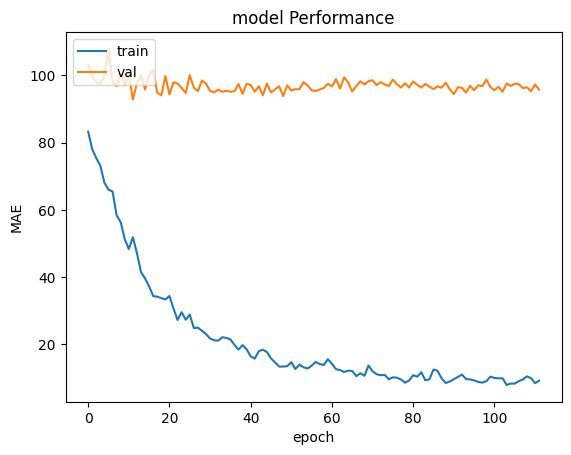

In [ ]:
plt.plot(k2_train_hist.history['mean_absolute_error'])
plt.plot(k2_train_hist.history['val_mean_absolute_error'])
plt.title('model Performance')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
predicted_labels = cur_model.predict(X_test)
print(predicted_labels)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[174.68146  154.00584 ]
 [176.13762  156.7708  ]
 [129.74828  105.24157 ]
 [105.384285 131.53795 ]
 [ 69.77256  173.91005 ]
 [103.89251  102.2316  ]
 [132.03145  186.27861 ]
 [128.35526  262.38806 ]
 [195.05823  279.5062  ]
 [143.9021   294.7615  ]
 [104.46221  277.838   ]
 [ 76.65316  158.78209 ]
 [154.63638  196.2361  ]
 [127.61082  236.39195 ]
 [ 81.73759  122.205086]
 [189.84586  172.76494 ]
 [220.92282  295.83807 ]
 [165.96712  208.17671 ]
 [116.76144  289.79202 ]
 [128.80261  438.6575  ]
 [ 85.21422  347.22385 ]
 [119.97239  381.70505 ]
 [ 87.552315 244.18657 ]
 [153.33209  314.18118 ]
 [141.39847  342.6791  ]
 [144.51352  293.49503 ]
 [182.64969  294.56473 ]
 [121.0295   129.6097  ]
 [126.84224  164.62563 ]
 [137.47716  187.83984 ]
 [ 72.745636 124.74151 ]
 [167.6145   248.38026 ]
 [220.58432  368.27313 ]
 [168.76337  247.11496 ]
 [130.85089  211.9641  ]
 [198.114     95.042534]
 [150.11438  220.93909 ]
 [174.90656  211.4229  ]
 [178.1412  

#### **Hperparameter Tuning**

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filters', [16, 24, 48]),
        kernel_size=(2, 2),
        activation='relu',
        padding='same',
        input_shape=(6, 291, 1)
    ))

    # Optional MaxPooling layer
    if hp.Boolean('use_maxpool_1'):
        model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filters', [16, 24, 48]),
        kernel_size=(2, 2),
        activation='relu',
        padding='same'
    ))

    # Optional MaxPooling layer
    if hp.Boolean('use_maxpool_2'):
        model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_3_filters', [16, 24, 48]),
        kernel_size=(2, 2),
        activation='relu',
        padding='same'
    ))

    model.add(layers.Flatten())

    # Optional fully connected layers
    model.add(layers.Dense(hp.Choice('dense_1_units', [64, 128, 256, 512]), activation='linear'))

    if hp.Boolean('use_second_dense'):
        model.add(layers.Dense(hp.Choice('dense_2_units', [64, 128, 256, 512]), activation='linear'))

    # Output layer with 2 nodes for regression
    model.add(layers.Dense(2, activation='linear'))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
# Define a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='cnn_tuning'
)
# Perform the search
tuner.search(X_train, y_train_xy, epochs=100, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)


Trial 20 Complete [00h 02m 03s]
val_mean_absolute_error: 85.50537109375

Best val_mean_absolute_error So Far: 84.6170883178711
Total elapsed time: 00h 55m 01s
{'conv_1_filters': 48, 'conv_1_kernel_size_0': 3, 'conv_1_kernel_size_1': 2, 'use_maxpool_1': True, 'conv_2_filters': 48, 'conv_2_kernel_size_0': 2, 'conv_2_kernel_size_1': 2, 'use_maxpool_2': True, 'conv_3_filters': 48, 'conv_3_kernel_size_0': 3, 'conv_3_kernel_size_1': 3, 'dense_1_units': 64, 'use_second_dense': False, 'dense_2_units': 512}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 6, 291, 48)          │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 145, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 145, 48)          │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 72, 48)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 72, 48)           │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         221,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,146 (938.07 KB)

 Trainable params: 240,146 (938.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
predicted_labels = best_model.predict(X_test)
print(predicted_labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[161.53278  112.65764 ]
 [156.18454  173.32938 ]
 [105.65193  111.29627 ]
 [133.74628   79.48226 ]
 [112.67631  102.89204 ]
 [118.08783  -75.327156]
 [ 87.03446  345.0674  ]
 [115.383995 338.54166 ]
 [189.0679    76.771675]
 [125.26628  332.88336 ]
 [116.26663  346.4677  ]
 [ 87.09727  130.58868 ]
 [137.11635  201.48445 ]
 [109.87275  227.10808 ]
 [ 65.820915 151.7783  ]
 [146.04976   90.88791 ]
 [182.04007  145.96704 ]
 [180.86002  158.8978  ]
 [ 72.86383  458.07996 ]
 [108.33445  398.0881  ]
 [127.55584  335.18433 ]
 [155.16235  321.77454 ]
 [ 82.48594  340.4568  ]
 [167.27274  389.60754 ]
 [138.0765   515.3939  ]
 [144.4609   336.48334 ]
 [148.06989  444.00848 ]
 [143.10849   67.67251 ]
 [132.82228  218.2174  ]
 [127.92879  153.72874 ]
 [105.554634  56.943813]
 [158.01357  334.04144 ]
 [193.52948  358.18884 ]
 [152.63647  403.25995 ]
 [119.35668  229.56174 ]
 [185.47044   81.17423 ]
 [156.56929  180.75237 ]
 [155.21356  302.91785 ]
 [161.34898 

#### **Results Visualization Functions**

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

k2_mic_pos = [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ]

k1_mic_pos = [
    [152.3, 0, 77],
    [137.4, 0, 75],
    [133.4, 0, 74],
    [129.7, 0, 74]
]

# Environment traits
mins = (0, 0, 0)
maxs = (282, 400, 75)
grid_resolution = 1
table_start = 330
table_end = 400

# Microphone positions in 3D
mics_k1 = k1_mic_pos
mics_k2 = k2_mic_pos

microphone_xs_k1 = [sublist[0] for sublist in mics_k1]
microphone_ys_k1 = [sublist[1] for sublist in mics_k1]
microphone_zs_k1 = [sublist[2] for sublist in mics_k1]

microphone_xs_k2 = [sublist[0] for sublist in mics_k2]
microphone_ys_k2 = [sublist[1] for sublist in mics_k2]
microphone_zs_k2 = [sublist[2] for sublist in mics_k2]

# Extract margins
x_min, y_min, z_min = mins
x_max, y_max, z_max = maxs
table_y_min = 330
table_y_max = 400
table_x_min = 70
table_x_max = 210
table_z = 75


def plot_points(positions, predicted, pred_dict, num_of_mics, has_z=True, plot_refined=False):
    # Example lists of positions
    actual_positions = positions
    predicted_positions = predicted
    # refined_predicted_positions = refined

    # mic positions
    mic_xs = (microphone_xs_k1, microphone_xs_k2)
    mic_ys = (microphone_ys_k1, microphone_ys_k2)
    mic_zs = (microphone_zs_k1, microphone_zs_k2)

    # Create a 3D plot
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the positions for plotting
    actual_x, actual_y, actual_z = zip(*actual_positions)
    if not has_z:
        predicted_x, predicted_y = zip(*predicted_positions)
        predicted_z = actual_z
    else:
        predicted_x, predicted_y, predicted_z = zip(*predicted_positions)
    # refined_x, refined_y, refined_z = zip(*refined_predicted_positions)

    # Plot the points
    ax.scatter(actual_x, actual_y, actual_z, c='r', marker='o', label='Actual')
    ax.scatter(predicted_x, predicted_y, predicted_z, c='b', marker='^', label='Predicted')
    if plot_refined:
        ax.scatter(refined_x, refined_y, refined_z, c='g', marker='s', label='Refined Predicted')

    # Connect the actual points to predicted and refined predicted points
    for i in range(len(actual_positions)):
        ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], [actual_z[i], predicted_z[i]], c='b', linestyle='dashed')
        if plot_refined:
            ax.plot([actual_x[i], refined_x[i]], [actual_y[i], refined_y[i]], [actual_z[i], refined_z[i]], c='g', linestyle='dotted')

    # Plot microphone points
    if num_of_mics == 1:
        ax.scatter(mic_xs[0], mic_ys[0], mic_zs[0], marker='s', c='purple', label='Microhpones')
        for j in range(len(microphone_xs_k1)):
            ax.plot([mic_xs[0][j], mic_xs[0][j]], [mic_ys[0][j], mic_ys[0][j]], [mic_zs[0][j], 0], c='purple', linestyle='solid')
    elif num_of_mics == 2:
        ax.scatter(mic_xs[1], mic_ys[1], mic_zs[1], marker='s', c='purple', label='Microhpones')
        for j in range(len(microphone_xs_k2)):
            ax.plot([mic_xs[1][j], mic_xs[1][j]], [mic_ys[1][j], mic_ys[1][j]], [mic_zs[1][j], 0], c='purple', linestyle='solid')
    elif num_of_mics == 3:
        ax.scatter(mic_xs, mic_ys, mic_zs, marker='s', c='purple', label='Microhpones')
        for i in range(num_of_mics - 1):
            for j in range(len(microphone_xs_k1)):
                ax.plot([mic_xs[i][j], mic_xs[i][j]], [mic_ys[i][j], mic_ys[i][j]], [mic_zs[i][j], 0], c='purple', linestyle='solid')

    # Set grid dimensions
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

    # Highlight the table range horizontally with 3D polygons
    table_vertices = [
        [(table_x_min, table_y_min, 0), (table_x_max, table_y_min, 0), (table_x_max, table_y_min, table_z), (table_x_min, table_y_min, table_z)],
        [(table_x_min, table_y_min, table_z), (table_x_max, table_y_min, table_z), (table_x_max, table_y_max, table_z), (table_x_min, table_y_max, table_z)]
    ]

    ax.add_collection3d(Poly3DCollection(table_vertices, color='gray', alpha=0.3))

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
import math
NOT_VALID = -1

def calculate_error(pred_dict, has_z=True):
    errors_pred = {
        'er_x': [],
        'er_y': [],
        'er_z': [],
        'total_errors': []
    }
    # Calculate error for preds
    for actual_pos, pred in pred_dict.items():
        if len(actual_pos) != len(pred):
            return NOT_VALID
        else:
            if has_z:
                x_final, y_final, z_final = pred
                errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
                errors_pred['er_z'].append(abs((actual_pos[2] - z_final)))
                errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
                errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2 + (actual_pos[2] - z_final)**2))
            elif not has_z:
                x_final, y_final = pred
                errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
                errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
                errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2))

    # Calculate means for preds
    means_pred = {}
    for er_name, errors in errors_pred.items():
        mean = np.mean(errors)
        means_pred['mean_of_' + er_name + ' for prediction'] = mean
    if not has_z:
        means_pred['mean_of_' + 'er_z' + ' for prediction'] = 'Unvalid'
    return means_pred

In [ ]:
def average_predictions(predicted, actual_labels):
    pred_dict = {}
    for label in actual_labels.tolist():
        pred_dict[tuple(label)] = []
    for i in range(len(predicted)):
        pred_dict[tuple(actual_labels[i])].append(predicted[i].tolist())
    for key in pred_dict.keys():
        pred_dict[key] = np.mean(pred_dict[key], axis=0).tolist()
    return list(pred_dict.keys()), list(pred_dict.values()), pred_dict

In [ ]:
def extract_unique_lists(two_dim_list):
    seen = set()
    unique_lists = []

    for sublist in two_dim_list:
        # Convert the sublist to a tuple so it can be added to a set
        sublist_tuple = tuple(sublist)

        # If the tuple is not in the seen set, add it
        if sublist_tuple not in seen:
            seen.add(sublist_tuple)
            unique_lists.append(sublist.tolist())

    return unique_lists

#### **Results Visualization**

In [ ]:
actuals, predictions, pred_dict = average_predictions(predicted_labels, y_test_xy)
means_pred = calculate_error(pred_dict, has_z=False)

In [ ]:
print(extract_unique_lists(y_test))
print(pred_dict)

[[4, 192, 0], [5, 5, 0], [56, 338, 0], [60, 4, 0], [75, 395, 74], [78, 340, 74], [100, 340, 74], [102, 26, 0], [109, 327, 0], [137, 193, 0], [150, 360, 74], [170, 380, 74], [173, 69, 0], [185, 191, 0], [200, 395, 74], [210, 360, 74], [223, 284, 0], [227, 392, 0], [277, 5, 0], [232, 189, 0]]
{(4, 192): [144.71046193440756, 193.49804306030273], (5, 5): [133.83423900604248, 144.02172183990479], (56, 338): [158.87850284576416, 251.15077209472656], (60, 4): [134.71166896820068, 192.7749719619751], (75, 395): [159.27138423919678, 237.3504524230957], (78, 340): [144.38463592529297, 296.4247627258301], (100, 340): [170.3799648284912, 299.062047958374], (102, 26): [133.46241855621338, 142.58062362670898], (109, 327): [180.9325154622396, 282.20650990804035], (137, 193): [151.05225563049316, 180.61722087860107], (150, 360): [173.4091911315918, 315.1985263824463], (170, 380): [178.90645163399833, 249.05550166538782], (173, 69): [153.2181215286255, 164.32414436340332], (185, 191): [169.040473937988

Number of Training Samples: 278
Number of Test Samples: 153
Method: Feeding the model the patterns straight forward.
Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 6, 291, 24)          │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 145, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 145, 48)          │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 145, 48)          │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       5,345,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,080,632 (61.34 MB)

 Trainable params: 5,360,210 (20.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,720,422 (40.90 MB)





Results for model predictions:
 {'mean_of_er_x for prediction': 60.83932654517038, 'mean_of_er_y for prediction': 86.15956021667947, 'mean_of_er_z for prediction': 'Unvalid', 'mean_of_total_errors for prediction': 114.87081655361115}


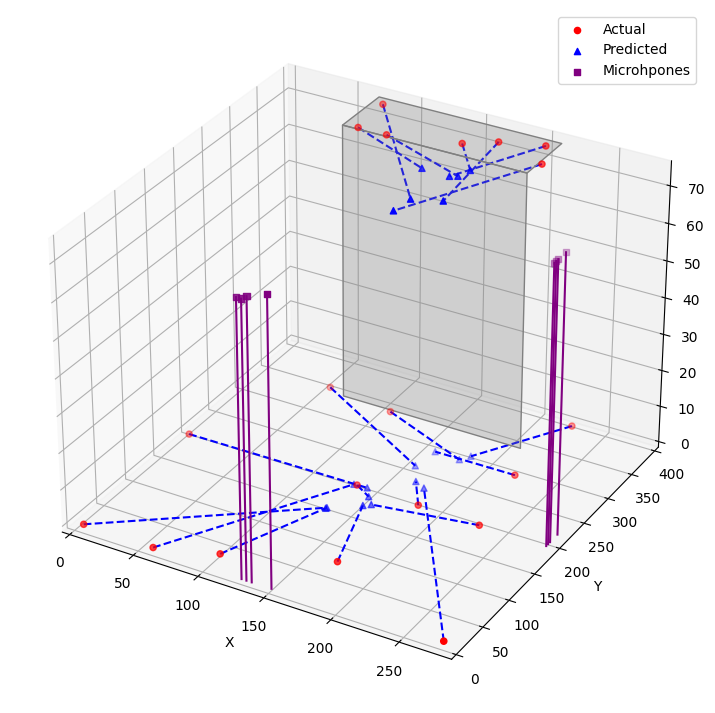

-----------
Actual: (4, 192)
Predicted [144.71046193440756, 193.49804306030273]
-----------
Actual: (5, 5)
Predicted [133.83423900604248, 144.02172183990479]
-----------
Actual: (56, 338)
Predicted [158.87850284576416, 251.15077209472656]
-----------
Actual: (60, 4)
Predicted [134.71166896820068, 192.7749719619751]
-----------
Actual: (75, 395)
Predicted [159.27138423919678, 237.3504524230957]
-----------
Actual: (78, 340)
Predicted [144.38463592529297, 296.4247627258301]
-----------
Actual: (100, 340)
Predicted [170.3799648284912, 299.062047958374]
-----------
Actual: (102, 26)
Predicted [133.46241855621338, 142.58062362670898]
-----------
Actual: (109, 327)
Predicted [180.9325154622396, 282.20650990804035]
-----------
Actual: (137, 193)
Predicted [151.05225563049316, 180.61722087860107]
-----------
Actual: (150, 360)
Predicted [173.4091911315918, 315.1985263824463]
-----------
Actual: (170, 380)
Predicted [178.90645163399833, 249.05550166538782]
-----------
Actual: (173, 69)
Predicte

In [ ]:
print('Number of Training Samples:', len(X_train))
print('Number of Test Samples:', len(X_test))
print('Method: Feeding the model the patterns straight forward.')
print('Model Summary:')
cur_model.summary()
print('\n\n\n')

print('Results for model predictions:\n', means_pred)

unique_lbls = extract_unique_lists(y_test)
plot_points(unique_lbls, predictions, pred_dict, 3, has_z=False)

for pos, pred in pred_dict.items():
    print('-----------')
    print('Actual:', pos)
    print('Predicted', pred)

### **K1 and K2 Training - Or more seperated bounces training**

#### **Training Process**

In [ ]:
print(len(train_dict_total), len(test_dict_total))
print(type(train_dict_total[(4, 192, 0)]), type(test_dict_total[(4, 192, 0)]))

57 20
<class 'list'> <class 'numpy.ndarray'>


In [ ]:
def stack_patterns_and_labels_train(dict_of_pats):
    lbls = []
    patterns = []
    for lbl, pats in dict_of_pats.items():
        for pt in pats:
            lbls.append(lbl)
            patterns.append(pt)
    return np.array(lbls), np.array(patterns)

def stack_patterns_and_labels_test(dict_of_pats):
    lbls = []
    patterns = []
    for lbl, pt in dict_of_pats.items():
        lbls.append(lbl)
        patterns.append(pt)
    return np.array(lbls), np.array(patterns)

In [ ]:
train_labels, train_patterns = stack_patterns_and_labels_train(train_dict_total)
test_labels, test_patterns = stack_patterns_and_labels_test(test_dict_total)
print(train_labels.shape, train_patterns.shape)
print(test_labels.shape, test_patterns.shape)

(197, 3) (197, 6, 291)
(20, 3) (20, 6, 291)


In [ ]:
train_shape = list(train_patterns.shape)
train_shape.append(1)
train_shape = tuple(train_shape)
input_shape = train_shape[1:]
print(train_shape, input_shape)

(197, 6, 291, 1) (6, 291, 1)


In [ ]:
X_train = train_patterns
y_train = train_labels
y_train_xy = np.array([[x, y] for [x, y, _] in y_train])
X_test = test_patterns
y_test = test_labels
y_test_xy = np.array([[x, y] for [x, y, _] in y_test])

In [ ]:
cur_model = get_network(input_shape, summary=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 6, 291, 48)          │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 145, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 3, 145, 48)          │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 1, 72, 48)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 1, 72, 48)           │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 904,514 (3.45 MB)

 Trainable params: 904,514 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [ ]:
# Compile the model
cur_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

# train the model
# k1_train_hist = cur_model.fit(X_train, y_train_xy, epochs=500, batch_size=5, validation_split=0.2, callbacks=[early_stop])
k1and2_hist = cur_model.fit(X_train, y_train_xy, epochs=500, batch_size=8, validation_split=0.2, callbacks=[early_stop])

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 161.2746 - mean_absolute_error: 161.2746 - val_loss: 87.3240 - val_mean_absolute_error: 87.3240
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 98.1021 - mean_absolute_error: 98.1021 - val_loss: 81.6301 - val_mean_absolute_error: 81.6301
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 95.0641 - mean_absolute_error: 95.0641 - val_loss: 79.5368 - val_mean_absolute_error: 79.5368
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 87.2390 - mean_absolute_error: 87.2390 - val_loss: 75.7189 - val_mean_absolute_error: 75.7189
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 83.8681 - mean_absolute_error: 83.8681 - val_loss: 83.6945 - val_mean_absolute_error: 83.6945
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 86.8577 - mean_absolute_error: 86.8577 - val_loss: 79.3644 - val_mean_absolute_error: 79.3644
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 85.6753 - mean

In [ ]:
predicted_labels = cur_model.predict(X_test)
print(len(predicted_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
20


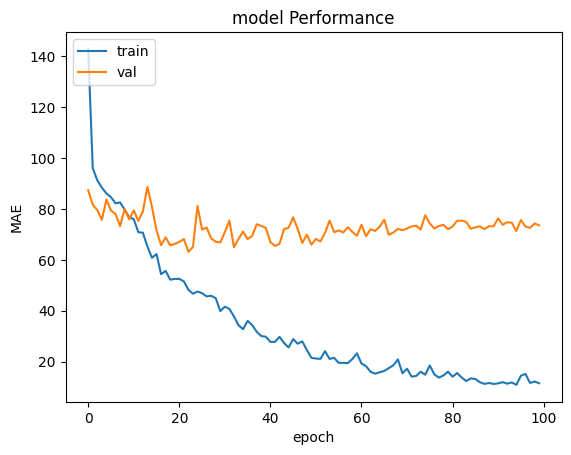

In [ ]:
import matplotlib.pyplot as plt

hist = k1and2_hist
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model Performance')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Hperparameter Tuning**

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filters', [16, 24, 48]),
        kernel_size=(2, 2),
        activation='relu',
        padding='same',
        input_shape=(6, 291, 1)
    ))

    # Optional MaxPooling layer
    if hp.Boolean('use_maxpool_1'):
        model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filters', [16, 24, 48]),
        kernel_size=(2, 2),
        activation='relu',
        padding='same'
    ))

    # Optional MaxPooling layer
    if hp.Boolean('use_maxpool_2'):
        model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_3_filters', [16, 24, 48]),
        kernel_size=(2, 2),
        activation='relu',
        padding='same'
    ))

    model.add(layers.Flatten())

    # Optional fully connected layers
    model.add(layers.Dense(hp.Choice('dense_1_units', [64, 128, 256, 512]), activation='linear'))

    if hp.Boolean('use_second_dense'):
        model.add(layers.Dense(hp.Choice('dense_2_units', [64, 128, 256, 512]), activation='linear'))

    # Output layer with 2 nodes for regression
    model.add(layers.Dense(2, activation='linear'))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
# Define a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='cnn_tuning'
)
# Perform the search
tuner.search(X_train, y_train_xy, epochs=100, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)


Trial 20 Complete [00h 02m 03s]
val_mean_absolute_error: 85.50537109375

Best val_mean_absolute_error So Far: 84.6170883178711
Total elapsed time: 00h 55m 01s
{'conv_1_filters': 48, 'conv_1_kernel_size_0': 3, 'conv_1_kernel_size_1': 2, 'use_maxpool_1': True, 'conv_2_filters': 48, 'conv_2_kernel_size_0': 2, 'conv_2_kernel_size_1': 2, 'use_maxpool_2': True, 'conv_3_filters': 48, 'conv_3_kernel_size_0': 3, 'conv_3_kernel_size_1': 3, 'dense_1_units': 64, 'use_second_dense': False, 'dense_2_units': 512}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 6, 291, 48)          │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 145, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 145, 48)          │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 72, 48)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 72, 48)           │           9,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         221,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,146 (938.07 KB)

 Trainable params: 240,146 (938.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
predicted_labels = best_model.predict(X_test)
print(predicted_labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[161.53278  112.65764 ]
 [156.18454  173.32938 ]
 [105.65193  111.29627 ]
 [133.74628   79.48226 ]
 [112.67631  102.89204 ]
 [118.08783  -75.327156]
 [ 87.03446  345.0674  ]
 [115.383995 338.54166 ]
 [189.0679    76.771675]
 [125.26628  332.88336 ]
 [116.26663  346.4677  ]
 [ 87.09727  130.58868 ]
 [137.11635  201.48445 ]
 [109.87275  227.10808 ]
 [ 65.820915 151.7783  ]
 [146.04976   90.88791 ]
 [182.04007  145.96704 ]
 [180.86002  158.8978  ]
 [ 72.86383  458.07996 ]
 [108.33445  398.0881  ]
 [127.55584  335.18433 ]
 [155.16235  321.77454 ]
 [ 82.48594  340.4568  ]
 [167.27274  389.60754 ]
 [138.0765   515.3939  ]
 [144.4609   336.48334 ]
 [148.06989  444.00848 ]
 [143.10849   67.67251 ]
 [132.82228  218.2174  ]
 [127.92879  153.72874 ]
 [105.554634  56.943813]
 [158.01357  334.04144 ]
 [193.52948  358.18884 ]
 [152.63647  403.25995 ]
 [119.35668  229.56174 ]
 [185.47044   81.17423 ]
 [156.56929  180.75237 ]
 [155.21356  302.91785 ]
 [161.34898 

## **End-to-End CNN network, Fed with the raw Audio Data**

At first for this section, we are to implement the structure proposed in the 'End-to-End Localization: From Audio...' and get the intial results corresponding to this architecture.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

def get_raw_data_model(inp_shape, summary=False):
    # Define the model
    model = models.Sequential()

    # First convolutional layer with 96 kernels of size 2x7
    model.add(layers.Conv2D(96, (2, 10), activation='relu', padding='same', input_shape=inp_shape))
    # Max pooling layer with size 7x7 (same size as the layer's kernels)
    model.add(layers.MaxPooling2D((2, 10)))

    # Second convolutional layer with 96 kernels of size 2x7
    model.add(layers.Conv2D(96, (2, 7), activation='relu', padding='same'))

    # Third convolutional layer with 128 kernels of size 2x5
    model.add(layers.Conv2D(128, (2, 5), activation='relu', padding='same'))
    # Max pooling layer with size 2x7 (same size as the layer's kernels)
    model.add(layers.MaxPooling2D((2, 5)))

    # Fourth convolutional layer with 128 kernels of size 2x5
    model.add(layers.Conv2D(128, (2, 5), activation='relu', padding='same'))
    # Max pooling layer with size 5x5 (same size as the layer's kernels)
    model.add(layers.MaxPooling2D((1, 5)))

    # Fifth convolutional layer with 128 kernels of size 1x3
    model.add(layers.Conv2D(128, (1, 3), activation='relu'))

    # Flatten the output for the fully connected layers
    model.add(layers.Flatten())

    # Fully connected layer with 500 nodes
    model.add(layers.Dense(500, activation='relu'))
    # Add Dropout with rate 0.5
    model.add(Dropout(0.5))
    # Output layer with 2 nodes (for regression with 2 outputs)
    model.add(layers.Dense(3, activation='linear'))

    # Summary of the model
    if summary:
        model.summary()

    return model

### **Training Procedure**

Here, we'll use the padded raw data and then apply the training process using the above end-to-end localization model.

In [ ]:
X_k1_raw = np.array(raw_k1_data_padded)
# X_k1_raw = np.reshape(X_k1_raw, (X_k1_raw.shape[0], X_k1_raw.shape[2], X_k1_raw.shape[1]))
y_k1_raw = np.array(raw_k1_labels)
print(X_k1_raw.shape, y_k1_raw.shape)

X_k2_raw = np.array(raw_k2_data_padded)
# X_k2_raw = np.reshape(X_k2_raw, (X_k2_raw.shape[0], X_k2_raw.shape[2], X_k2_raw.shape[1]))
y_k2_raw = np.array(raw_k2_labels)
print(X_k2_raw.shape, y_k2_raw.shape)

(57, 4, 143040) (57, 3)
(57, 4, 135456) (57, 3)


### Now let's combine the samples of K1 and K2 together in order to be used for training later

In [ ]:
def find_core_index(array, label):
    for i in range(len(array)):
        cor = array[i]
        unequal = False
        for j in range(len(cor)):
            if cor[j] != label[j]:
                unequal = True
        if not unequal:
            return i
    return -1

def combine_raw_samples_of_K1_K2(X_k1, X_k2, y_k1, y_k2):
    X_k2_padded = pad_samples(X_k2, X_k1.shape[2])
    combined = []
    labels = []
    for i in range(len(y_k1)):
        lbl = y_k1[i]
        idx_k2 = find_core_index(y_k2, lbl)
        combined.append(np.append(X_k1[i], X_k2_padded[idx_k2], axis=0))
        labels.append(lbl)
    return np.array(combined), np.array(labels)

In [ ]:
combined_X, combined_y = combine_raw_samples_of_K1_K2(X_k1_raw, X_k2_raw, y_k1_raw, y_k2_raw)
print(combined_X.shape, combined_y)

(57, 8, 143040) [[272 188   0]
 [207 382  74]
 [220   6   0]
 [225 334   0]
 [190 340  74]
 [221  70   0]
 [190 360  74]
 [275 394   0]
 [206 337  74]
 [184   6   0]
 [140 394  74]
 [176  27   0]
 [141  27   0]
 [171 328   0]
 [160 340  74]
 [175 395  74]
 [140 314   0]
 [142  84   0]
 [142  69   0]
 [146 154   0]
 [102   6   0]
 [105 395  74]
 [130 340  74]
 [100 193   0]
 [115  69   0]
 [107 358  74]
 [126 208   0]
 [ 75 385  74]
 [120 380  74]
 [140 227   0]
 [ 54 393   0]
 [ 61  60   0]
 [ 74 363  74]
 [  8 392   0]
 [ 54 188   0]
 [ 62 124   0]
 [ 58 280   0]
 [200 395  74]
 [210 360  74]
 [277   5   0]
 [173  69   0]
 [150 360  74]
 [232 189   0]
 [185 191   0]
 [227 392   0]
 [223 284   0]
 [170 380  74]
 [  4 192   0]
 [ 75 395  74]
 [  5   5   0]
 [109 327   0]
 [ 78 340  74]
 [102  26   0]
 [ 56 338   0]
 [137 193   0]
 [100 340  74]
 [ 60   4   0]]


###  Rest of the training procedure


In the following, we are to split the dataset into train and test dataset. But we need to have in mind that **the split should be balanaced in terms of coordinates' distribution.**

For now, let's continue with a random split.

In [ ]:
from sklearn.model_selection import train_test_split

# Make test and train datasets
X_k1_train, X_k1_test, y_k1_train, y_k1_test = train_test_split(X_k1_raw, y_k1_raw, test_size=0.2)
X_k2_train, X_k2_test, y_k2_train, y_k2_test = train_test_split(X_k2_raw, y_k2_raw, test_size=0.2)
combined_X_train, combined_X_test, combined_y_train, combined_y_test = train_test_split(combined_X, combined_y, test_size=0.2)

print(X_k1_train.shape, X_k1_test.shape)
print(X_k2_train.shape, X_k2_test.shape)
# print(y_k1_test, y_k2_test, sep='\n')
print(combined_X_train.shape, combined_X_test.shape)
print(combined_y_train, combined_y_test, sep='\n')

(45, 4, 143040) (12, 4, 143040)
(45, 4, 135456) (12, 4, 135456)
(45, 8, 143040) (12, 8, 143040)
[[ 54 393   0]
 [225 334   0]
 [ 75 385  74]
 [171 328   0]
 [277   5   0]
 [ 60   4   0]
 [206 337  74]
 [175 395  74]
 [227 392   0]
 [107 358  74]
 [ 75 395  74]
 [160 340  74]
 [ 58 280   0]
 [100 340  74]
 [185 191   0]
 [170 380  74]
 [210 360  74]
 [  8 392   0]
 [140 394  74]
 [140 227   0]
 [102   6   0]
 [176  27   0]
 [  4 192   0]
 [142  69   0]
 [105 395  74]
 [207 382  74]
 [100 193   0]
 [141  27   0]
 [150 360  74]
 [ 62 124   0]
 [140 314   0]
 [223 284   0]
 [ 61  60   0]
 [ 74 363  74]
 [115  69   0]
 [126 208   0]
 [ 56 338   0]
 [190 360  74]
 [137 193   0]
 [220   6   0]
 [130 340  74]
 [146 154   0]
 [184   6   0]
 [ 78 340  74]
 [142  84   0]]
[[190 340  74]
 [102  26   0]
 [ 54 188   0]
 [272 188   0]
 [109 327   0]
 [221  70   0]
 [275 394   0]
 [  5   5   0]
 [232 189   0]
 [120 380  74]
 [200 395  74]
 [173  69   0]]


In [ ]:
inp_size = X_k2_train.shape[1:]
inp_size = list(inp_size)
inp_szie = inp_size.append(1)
inp_size = tuple(inp_size)
print(inp_size)

(4, 135456, 1)


In [ ]:
raw_model = get_raw_data_model(inp_size, summary=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 4, 135456, 96)       │           2,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 13545, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 2, 13545, 96)        │         129,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 2, 13545, 128)       │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 2709, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 1, 2709, 128)        │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 541, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 1, 539, 128)         │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 68992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │      34,496,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,965,395 (133.38 MB)

 Trainable params: 34,965,395 (133.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

# Compile the model
raw_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

#from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

# train the model
k1_raw_train_hist = raw_model.fit(X_k2_train, y_k2_train, epochs=500, batch_size=8, validation_split=0.2, callbacks=[early_stop])
hist = k1_raw_train_hist

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 126.2768 - mean_absolute_error: 126.2768 - val_loss: 116.8776 - val_mean_absolute_error: 116.8776
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 113.5597 - mean_absolute_error: 113.5597 - val_loss: 84.6108 - val_mean_absolute_error: 84.6108
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - loss: 84.4122 - mean_absolute_error: 84.4122 - val_loss: 86.9065 - val_mean_absolute_error: 86.9065
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - loss: 83.8920 - mean_absolute_error: 83.8920 - val_loss: 89.5719 - val_mean_absolute_error: 89.5719
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - loss: 85.1109 - mean_absolute_error: 85.1109 - val_loss: 74.8980 - val_mean_absolute_error: 74.8980
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - loss: 78.0672 - mean_absolute_error: 78.0672 - val_loss: 88.5834 - val_mean_absolute_error: 88.5834
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - loss: 76.3188 - mean_abso

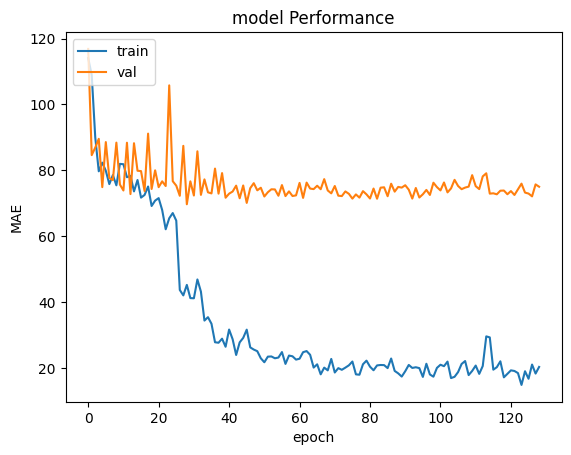

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model Performance')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
predicted_raw_labels = raw_model.predict(X_k2_test)
print(len(predicted_raw_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
12


## **MLP network**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Make the baseline model
def get_mlp(inp_shape, summary=False):

    # Define the model
    model = models.Sequential()

    # Add the first layer
    model.add()

## **Results Visualization Functions**

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

k2_mic_pos = [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ]

k1_mic_pos = [
    [152.3, 0, 77],
    [137.4, 0, 75],
    [133.4, 0, 74],
    [129.7, 0, 74]
]

# Environment traits
mins = (0, 0, 0)
maxs = (282, 400, 75)
grid_resolution = 1
table_start = 330
table_end = 400

# Microphone positions in 3D
mics_k1 = k1_mic_pos
mics_k2 = k2_mic_pos

microphone_xs_k1 = [sublist[0] for sublist in mics_k1]
microphone_ys_k1 = [sublist[1] for sublist in mics_k1]
microphone_zs_k1 = [sublist[2] for sublist in mics_k1]

microphone_xs_k2 = [sublist[0] for sublist in mics_k2]
microphone_ys_k2 = [sublist[1] for sublist in mics_k2]
microphone_zs_k2 = [sublist[2] for sublist in mics_k2]

# Extract margins
x_min, y_min, z_min = mins
x_max, y_max, z_max = maxs
table_y_min = 330
table_y_max = 400
table_x_min = 70
table_x_max = 210
table_z = 75


def plot_points(positions, predicted, pred_dict, num_of_mics, has_z=True, plot_refined=False):
    # Example lists of positions
    actual_positions = positions
    predicted_positions = predicted
    # refined_predicted_positions = refined

    # mic positions
    mic_xs = (microphone_xs_k1, microphone_xs_k2)
    mic_ys = (microphone_ys_k1, microphone_ys_k2)
    mic_zs = (microphone_zs_k1, microphone_zs_k2)

    # Create a 3D plot
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the positions for plotting
    actual_x, actual_y, actual_z = zip(*actual_positions)
    if not has_z:
        predicted_x, predicted_y = zip(*predicted_positions)
        predicted_z = actual_z
    else:
        predicted_x, predicted_y, predicted_z = zip(*predicted_positions)
    # refined_x, refined_y, refined_z = zip(*refined_predicted_positions)

    # Plot the points
    ax.scatter(actual_x, actual_y, actual_z, c='r', marker='o', label='Actual')
    ax.scatter(predicted_x, predicted_y, predicted_z, c='b', marker='^', label='Predicted')
    if plot_refined:
        ax.scatter(refined_x, refined_y, refined_z, c='g', marker='s', label='Refined Predicted')

    # Connect the actual points to predicted and refined predicted points
    for i in range(len(actual_positions)):
        ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], [actual_z[i], predicted_z[i]], c='b', linestyle='dashed')
        if plot_refined:
            ax.plot([actual_x[i], refined_x[i]], [actual_y[i], refined_y[i]], [actual_z[i], refined_z[i]], c='g', linestyle='dotted')

    # Plot microphone points
    if num_of_mics == 1:
        ax.scatter(mic_xs[0], mic_ys[0], mic_zs[0], marker='s', c='purple', label='Microhpones')
        for j in range(len(microphone_xs_k1)):
            ax.plot([mic_xs[0][j], mic_xs[0][j]], [mic_ys[0][j], mic_ys[0][j]], [mic_zs[0][j], 0], c='purple', linestyle='solid')
    elif num_of_mics == 2:
        ax.scatter(mic_xs[1], mic_ys[1], mic_zs[1], marker='s', c='purple', label='Microhpones')
        for j in range(len(microphone_xs_k2)):
            ax.plot([mic_xs[1][j], mic_xs[1][j]], [mic_ys[1][j], mic_ys[1][j]], [mic_zs[1][j], 0], c='purple', linestyle='solid')
    elif num_of_mics == 3:
        ax.scatter(mic_xs, mic_ys, mic_zs, marker='s', c='purple', label='Microhpones')
        for i in range(num_of_mics - 1):
            for j in range(len(microphone_xs_k1)):
                ax.plot([mic_xs[i][j], mic_xs[i][j]], [mic_ys[i][j], mic_ys[i][j]], [mic_zs[i][j], 0], c='purple', linestyle='solid')

    # Set grid dimensions
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

    # Highlight the table range horizontally with 3D polygons
    table_vertices = [
        [(table_x_min, table_y_min, 0), (table_x_max, table_y_min, 0), (table_x_max, table_y_min, table_z), (table_x_min, table_y_min, table_z)],
        [(table_x_min, table_y_min, table_z), (table_x_max, table_y_min, table_z), (table_x_max, table_y_max, table_z), (table_x_min, table_y_max, table_z)]
    ]

    ax.add_collection3d(Poly3DCollection(table_vertices, color='gray', alpha=0.3))

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
import math
NOT_VALID = -1

def calculate_error(pred_dict, has_z=True):
    errors_pred = {
        'er_x': [],
        'er_y': [],
        'er_z': [],
        'total_errors': []
    }
    # Calculate error for preds
    for actual_pos, pred in pred_dict.items():
        if len(actual_pos) != len(pred):
            return NOT_VALID
        else:
            if has_z:
                x_final, y_final, z_final = pred
                errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
                errors_pred['er_z'].append(abs((actual_pos[2] - z_final)))
                errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
                errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2 + (actual_pos[2] - z_final)**2))
            elif not has_z:
                x_final, y_final = pred
                errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
                errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
                errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2))

    # Calculate means for preds
    means_pred = {}
    for er_name, errors in errors_pred.items():
        mean = np.mean(errors)
        means_pred['mean_of_' + er_name + ' for prediction'] = mean
    if not has_z:
        means_pred['mean_of_' + 'er_z' + ' for prediction'] = 'Unvalid'
    return means_pred

In [ ]:
def average_predictions(predicted, actual_labels):
    pred_dict = {}
    for label in actual_labels.tolist():
        pred_dict[tuple(label)] = []
    for i in range(len(predicted)):
        pred_dict[tuple(actual_labels[i])].append(predicted[i].tolist())
    for key in pred_dict.keys():
        pred_dict[key] = np.mean(pred_dict[key], axis=0).tolist()
    return list(pred_dict.keys()), list(pred_dict.values()), pred_dict

In [ ]:
def extract_unique_lists(two_dim_list):
    seen = set()
    unique_lists = []

    for sublist in two_dim_list:
        # Convert the sublist to a tuple so it can be added to a set
        sublist_tuple = tuple(sublist)

        # If the tuple is not in the seen set, add it
        if sublist_tuple not in seen:
            seen.add(sublist_tuple)
            unique_lists.append(sublist.tolist())

    return unique_lists

## **Results Visualization**

In [ ]:
actuals, predictions, pred_dict = average_predictions(preicted_raw_labels, y_k2_test)
means_pred = calculate_error(pred_dict, has_z=True)

In [ ]:
print(extract_unique_lists(y_k2_test))
print(pred_dict)

[[225, 334, 0], [8, 392, 0], [190, 340, 74], [140, 314, 0], [140, 394, 74], [207, 382, 74], [120, 380, 74], [4, 192, 0], [171, 328, 0], [54, 188, 0], [227, 392, 0], [176, 27, 0]]
{(225, 334, 0): [160.65579223632812, 274.65765380859375, 24.042325973510742], (8, 392, 0): [176.70904541015625, 300.87548828125, 27.00956916809082], (190, 340, 74): [201.3968048095703, 381.6463928222656, 40.57546615600586], (140, 314, 0): [183.97308349609375, 314.5590515136719, 27.5064754486084], (140, 394, 74): [163.95703125, 280.86566162109375, 26.626739501953125], (207, 382, 74): [155.63706970214844, 266.9815673828125, 25.105175018310547], (120, 380, 74): [160.98936462402344, 275.4873046875, 24.212438583374023], (4, 192, 0): [189.41470336914062, 341.8780822753906, 36.16361618041992], (171, 328, 0): [169.69520568847656, 289.89959716796875, 25.024282455444336], (54, 188, 0): [189.63584899902344, 331.1351013183594, 33.42182159423828], (227, 392, 0): [161.39608764648438, 276.1754150390625, 24.357650756835938], 

In [ ]:
def give_kinects_index(k1=True, k2=False):
    if k1 and not k2:
        return 1
    elif k2 and not k1:
        return 2
    elif k1 and k2:
        return 3

Number of Training Samples: 45
Number of Test Samples: 12
Input Shhape: (4, 135456, 1)
Method: Results for End-to-End network, fed with 45 samples for and 12 samples for test.
Note that the samples used are original samples meaning they contain all of the bounces.
K1 samples used: False 
K2 samples used: True
Number of Possible Epochs: 500, Early Stopping Patience: 100. Stopped after 121 epochs.
Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 4, 135456, 96)       │           2,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 13545, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 2, 13545, 96)        │         129,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 2, 13545, 128)       │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 2709, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 1, 2709, 128)        │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 541, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 1, 539, 128)         │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 68992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │      34,496,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,896,187 (400.15 MB)

 Trainable params: 34,965,395 (133.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,930,792 (266.76 MB)





Results for model predictions:
 {'mean_of_er_x for prediction': 66.57334009806316, 'mean_of_er_y for prediction': 103.06177775065105, 'mean_of_er_z for prediction': 33.779866218566895, 'mean_of_total_errors for prediction': 138.49266798591216}


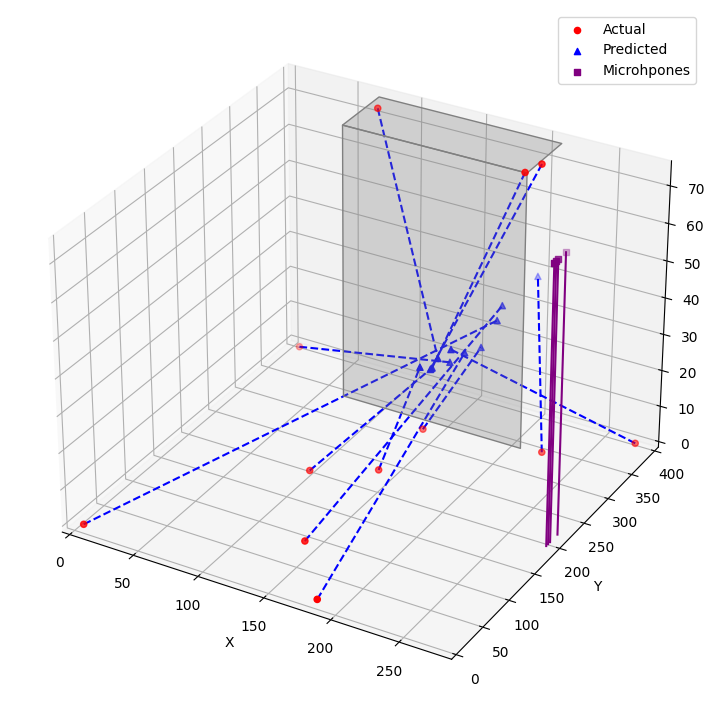

-----------
Actual: (225, 334, 0)
Predicted [160.65579223632812, 274.65765380859375, 24.042325973510742]
-----------
Actual: (8, 392, 0)
Predicted [176.70904541015625, 300.87548828125, 27.00956916809082]
-----------
Actual: (190, 340, 74)
Predicted [201.3968048095703, 381.6463928222656, 40.57546615600586]
-----------
Actual: (140, 314, 0)
Predicted [183.97308349609375, 314.5590515136719, 27.5064754486084]
-----------
Actual: (140, 394, 74)
Predicted [163.95703125, 280.86566162109375, 26.626739501953125]
-----------
Actual: (207, 382, 74)
Predicted [155.63706970214844, 266.9815673828125, 25.105175018310547]
-----------
Actual: (120, 380, 74)
Predicted [160.98936462402344, 275.4873046875, 24.212438583374023]
-----------
Actual: (4, 192, 0)
Predicted [189.41470336914062, 341.8780822753906, 36.16361618041992]
-----------
Actual: (171, 328, 0)
Predicted [169.69520568847656, 289.89959716796875, 25.024282455444336]
-----------
Actual: (54, 188, 0)
Predicted [189.63584899902344, 331.1351013183

In [ ]:
k_idx = give_kinects_index(k1=False, k2=True)
print('Number of Training Samples:', len(X_k2_train))
print('Number of Test Samples:', len(y_k2_test))
print('Input Shhape:', inp_size)
print('Method: Results for End-to-End network, fed with 45 samples for and 12 samples for test.\nNote that the samples used are original samples meaning they contain all of the bounces.')
print('K1 samples used:', False, '\nK2 samples used:', True)
print('Number of Possible Epochs: 500, Early Stopping Patience: 100. Stopped after 121 epochs.')
print('Model Summary:')
raw_model.summary()
print('\n\n\n')

print('Results for model predictions:\n', means_pred)

unique_lbls = extract_unique_lists(y_k1_test)
plot_points(unique_lbls, predictions, pred_dict, k_idx, has_z=True)

for pos, pred in pred_dict.items():
    print('-----------')
    print('Actual:', pos)
    print('Predicted', pred)